In [1]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

In [2]:
# ##############################################
# ##
# #scaling:
# #have Lagrange point as the origin
# #scale position so that the norm of the first position vector is 1
# #scale time so that the period of the orbit is 1
# ##############################################


# custom_position_scale_L1 = norm(halo_linear_L1_origin[1:3,1])

# custom_time_scale_L1 = h_L1_rk4*(N-1) 

# custom_velocity_scale_L1 = custom_position_scale_L1/custom_time_scale_L1

# custom_position_scale_L2 = norm(halo_linear_L2_origin[1:3,1])

# custom_time_scale_L2 = h_L2_rk4*(N-1) 

# custom_velocity_scale_L2 = custom_position_scale_L2/custom_time_scale_L2

# custom_units_L1 = [custom_position_scale_L1, custom_velocity_scale_L1, custom_time_scale_L1]

# custom_units_L2 = [custom_position_scale_L2, custom_velocity_scale_L2, custom_time_scale_L2]

# ##

In [3]:
# #scaled dynamics in the user defined custom units  
# function threebp_dynamics_scaled(x, u)
    
#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
    
#     x_original = [q_original; v_original]
    
#     if Lagrange_Point == "L1"
        
#         #L1 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [0.8369180073169304, 0,0,0,0,0]

#     else
        
#         #L2 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [1.1556799130947355,0,0,0,0,0]

#     end
    
#     #get it back to original units and without the L1 shift  
#     x_original_unshift = x_original+L
    
#     ẋ_original = zeros(eltype(x),6)
    
#     #calculate the original xdot (no scaling)
#     ẋ_original = threebp_dynamics(x_original_unshift, u)

#     #then scale these dynamics
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale
        
#     ẋ_scaled = [v_scaled; a_scaled]

#     return ẋ_scaled
# end

In [4]:
#from the Lyaponov orbit
#x0_lyapunov = [ 1.1556814491008298,
# -1.4319993886822296e-21,
#  0.0,
#  2.2212106056655213e-21,
# -8.333136405918907e-6,
#  0.0]



 #lyapunov_period = 3.3732524857835884


In [5]:
# T_og = 2.361e6 #in seconds - orbital period of m1 and m2
# time_scale_og = T_og/(2*pi)

In [6]:
#parameters for Earth Moon System
μ = 1.215e-2
μ1 = 1-μ
μ2 = μ

#position of mass 1
pose_m1 = [-μ, 0, 0]

#position of mass 2
pose_m2 = [1-μ, 0, 0]

#value obtained from 3BP textbook (original)
L = 3.850e5 #in km - distance between centers of m1 and m2
#V_ = 1.025 #in km/s - orbital velocity of m1
#T_ = 2.361e6 #in seconds - orbital period of m1 and m2

#updated for time unit to be in days
T_ = 2.361e6/86400 #in days - orbital period of m1 and m2
time_scale = T_/(2*pi)

#time unit of days
V_ = L/time_scale
acceleration_scale = L/((time_scale)^2)

#state of the L1 and L2 Lagrange points (computed offline)
XL1 = [0.8369180073169304, 0, 0, 0, 0, 0]
XL2 = [1.1556799130947355, 0, 0, 0, 0, 0]

6-element Vector{Float64}:
 1.1556799130947355
 0.0
 0.0
 0.0
 0.0
 0.0

In [7]:
acceleration_scale

20354.29089708545

In [8]:
time_scale

4.349129868518112

In [9]:
V_

88523.45449302066

In [10]:
function effective_potential(X)
    x = X[1]
    y = X[2]
    z = X[3]

    r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
    r2 = sqrt((x-μ1)^2 + y^2 + z^2)
    #assuming m3 is unit mass
   
    U = (-μ1/r1)-(μ2/r2)-0.5*(x^2+y^2)
   
    return U
    
end

effective_potential (generic function with 1 method)

In [11]:
function three_body_prob_dynamics(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]

    ẋ = zeros(eltype(x),6)
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] 
    ẋ[5] = -2*v[1] - U_q[2]
    ẋ[6] = -U_q[3]

    return ẋ
end

three_body_prob_dynamics (generic function with 1 method)

In [12]:
#x[1:6] -> state
#x[7:9] -> control inputs

#coming in with SI units
function three_body_prob_dynamics_wcontrol(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]
    u = x[7:9]

    ẋ = zeros(eltype(x),9)
    
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] + u[1] 
    ẋ[5] = -2*v[1] - U_q[2] + u[2]
    ẋ[6] = -U_q[3] + u[3]
    
    #zero order hold on the controls 
    ẋ[7:9] = zeros(3)

    return ẋ
end

three_body_prob_dynamics_wcontrol (generic function with 1 method)

In [13]:
#this just scales the dynamics by L and V_

In [14]:
#inputs are in the custom SI unit scale

function three_body_prob_dynamics_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    
    x_original = [q_original; v_original]

    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = three_body_prob_dynamics(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_scaled (generic function with 1 method)

In [15]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = x[7:9]/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled; u_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled (generic function with 1 method)

In [16]:
#this shifts the origin to L2 and scales by custom scales

In [17]:
# #inputs are in the custom scaled units

# function three_body_dynamics_scaled(x)

#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
    
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
    
#     x_original = [q_original; v_original]

#     #get it back to original units and without the L2 shift  
#     x_original_unshift = x_original+ XL2

#     ẋ_original = zeros(eltype(x),6)

#     #calculate the original xdot (no scaling)

#     ẋ_original = three_body_prob_dynamics(x_original_unshift)

#     #then scale the output
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale

#     ẋ_scaled = [v_scaled; a_scaled]

#     return ẋ_scaled

# end

In [18]:
# #inputs are in the custom scaled units

# function three_body_dynamics_wcontrol_scaled(x)

#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
#     u_original = zeros(eltype(x),3)
    
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
#     u_original = x[7:9]*custom_acceleration_scale
    
#     x_original = [q_original; v_original]

#     #get it back to original units and without the L2 shift  
#     x_original_unshift = x_original+ XL2

#     ẋ_original = zeros(eltype(x),9)

#     #x in regular units
#     x_reg = [x_original_unshift; u_original]

#     #calculate the original xdot (no scaling)

#     ẋ_original = three_body_prob_dynamics_wcontrol(x_reg)

#     #then scale the output
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale

#     u_scaled = ẋ_original[7:9]/custom_accel_scale

#     ẋ_scaled = [v_scaled; a_scaled; u_scaled]

#     return ẋ_scaled

# end

In [19]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL_wcontrol!(du, u, p, t)
    
    #original CR3BP units
    #du[1:9] = three_body_prob_dynamics_wcontrol(u[1:9])

    #scaled units
    du[1:9] = three_body_prob_dynamics_wcontrol_scaled(u[1:9])
    
end

ST_and_dynamics_DFJL_wcontrol! (generic function with 1 method)

In [20]:
#ensure that the x_0 coming in and the period are in scaled units

function dynamics_wcontrol_integrate(x_0,period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL_wcontrol!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_wcontrol_integrate (generic function with 1 method)

In [21]:
#input is the initial condition
#control trajectory u (size N-1)

#integrate every half orbit

#u is size 20

#40 knot points in one rev. each of them are equally spaced apart


#ensure everything is in scaled units
function integrate_halfperiod(x_0, u)
    
    #u will be size 20
    
    #x trajectory not delta x 

    xtraj = zeros(6, 21)

    xtraj[:,1] = x_0

    #go through all the controls
    for i=1:20
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        #has the scaling included
        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)

        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
        
    end
    
    #this is size N. 21. Element 21 is the new 1
    return xtraj
        
end

integrate_halfperiod (generic function with 1 method)

In [22]:
function integrate_oneperiod(x_0, u)
    
    #u will be size 40 since we only want to apply the controls for one rev
    
    #x trajectory not delta x 

    xtraj = zeros(6, N_period)

    xtraj[:,1] = x_0

    for i=1:N_period-1
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)

        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
    end
    
    #this is size N. 40 for this case
    return xtraj
        
end

integrate_oneperiod (generic function with 1 method)

In [23]:
#ODE for the state transition matrix 

function phi_ode(z)
    
    #state vector
    x = z[1:6]
    
    #state transition matrix
    Φ = reshape(z[7:end], (6,6))
    
    #Find the dynamics jacobian at the state vector (CR3BP dynamics)
    #F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics(dx), x)

    #scaled dynamics
    F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics_scaled(dx), x)
    
    #Differential Equation of State transition Matrix
    Φ_dot = F*Φ
    
    return vec(Φ_dot)
    
end

phi_ode (generic function with 1 method)

In [24]:
#3BP dynamics and state transition matrix dynamics in one function 
function ST_and_dynamics(z)
    x = z[1:6]
    Φ = z[7:end]
    
    x_dot = three_body_prob_dynamics_scaled(x)
    Φ_dot = phi_ode(z)
    
    z_dot = [x_dot; Φ_dot]
    
    return z_dot
end

ST_and_dynamics (generic function with 1 method)

In [25]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    du[7:end] = phi_ode(u)
    
end

ST_and_dynamics_DFJL! (generic function with 1 method)

In [26]:
#solve using DifferentialEquations.jl
function justdynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    
end

justdynamics_DFJL! (generic function with 1 method)

In [27]:
#gets the state and state transition matrix for the entire solution

function get_state_stm(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    all_stm = zeros(6,6,N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
        all_stm[:,:,i] = reshape(solution.u[i][7:end], (6,6)) 
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states, all_stm, solution.t 
end

get_state_stm (generic function with 1 method)

In [28]:
#gets the state and transition matrix for the entire solution

function get_state_wcontrol(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(9, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:9]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state_wcontrol (generic function with 1 method)

In [29]:
#gets the state and transition matrix for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [30]:

#this solved until we cross the xz plane
function diff_solve(x_0, period)
    
    #stop when y=0
    condition(u,t,integrator) = u[2]
    
    affect!(integrator) = terminate!(integrator)
    
    cb = ContinuousCallback(condition, affect!)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol = 1e-12, reltol=1e-12, callback=cb)
    
    return sol
    
end

diff_solve (generic function with 1 method)

In [31]:
#integrate dynamics and state transition matrix
function dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_integrate (generic function with 1 method)

In [32]:
#integrate just the dynamics
function just_dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(justdynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate (generic function with 1 method)

In [33]:
T_ 

27.32638888888889

In [34]:
time_scale 

4.349129868518112

In [35]:
using DelimitedFiles
#period of the halo orbit. From ThreeBodyProblem.jl (in CR3BP units)
T = 3.4071472466192527

#period in custom units
T_scaled = T*time_scale

#read in the initial guess trajectory. Richardson expansion from ThreeBodyProblem.jl
richardson  = readdlm("richardsonL2.txt", '\t', Float64, '\n')'

#in CR3BP units
x0_L2 = richardson[:,1]

x0_L2_scaled = [x0_L2[1:3]*L; x0_L2[4:6]*V_]

#for lyaponov
#x0_L2 = x0_lyapunov

#T = lyapunov_period

6-element Vector{Float64}:
 431249.946141646
      0.0
   5642.062948909701
      0.0
  15342.188285037404
      0.0

In [36]:
#linearize the dynamics about the L2 Lagrange Point and go in the planar direction
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), XL2)

In [37]:
#nonzero_cmplx_eigen_L2 = cmplx_eigen_L2[cmplx_eigen_L2 .!=0]

In [38]:
#marginally stable directions (periodic motion)
#direction2_L2 = A_L2_eigen.vectors[:, 2]
#direction3_L2 = A_L2_eigen.vectors[:, 3]
#direction4_L2 = A_L2_eigen.vectors[:, 4]
#direction5_L2 = A_L2_eigen.vectors[:, 5]

In [39]:
#display(direction2_L2)
#display(direction3_L2)
#display(direction4_L2)
#display(direction5_L2)
#directions 2 and 3 correspond to out of plane motion. We will select a perturbation
#in plane to get a Lyaponov orbit

In [40]:
#nonzero_cmplx_eigen_L2

In [41]:
#real(direction2_L2)

In [42]:
#real(direction3_L2)

In [43]:
#real(direction4_L2)

In [44]:
#real(direction5_L2)

In [45]:
#we will perturb the L2 lagrange point by direction 5 (planar stable direction)
#approximate the period of Lyaponov orbit with T = |omega|/(2π) where omega = |λ_5|

#λ_planar = norm(A_L2_eigen.values[5])
#T_planar = 2*pi/λ_planar

#set T to whatever direction you use
#T = T_planar

#weight of the perturbation (1e-3 works)
#w2 = 1e-5

#this is the perturbation in the planar direction
#perturbation_planar_L2 = w2*(real(direction5_L2))

#this is a linear combination between both of the directions
#x0_L2 = XL2 + perturbation_planar_L2

In [46]:
#Integrate the dynamics with the initial state of the Richardson expansion as the first state
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2_scaled; Φ_0]

solution_in = dynamics_integrate(x_0_stm, T_scaled)

all_state_in, stm_in, sol_t_in = get_state_stm(solution_in)

([431249.946141646 431249.9461444589 … 369490.75767211843 369665.9710674244; 0.0 2.1072953725303933 … -44953.87864401415 -45157.53537525589; … ; 15342.188285037404 15342.188246755026 … -2970.8002948868807 -1571.3827010134341; 0.0 -0.23903800908705172 … 2253.1489980700185 2425.087423840762], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.00000000622429 5.594567641213317e-14 … 4.337843062628147e-9 3.924109594110078e-14; -2.434276316857394e-14 0.9999999975890765 … 0.0001373529858999031 1.8119307154423863e-19; … ; -5.316833039735577e-10 -3.510551179617628e-5 … 0.999999995594267 5.2767129716926075e-15; 1.2480045464823515e-5 2.5469638239204106e-10 … 4.136769856380186e-14 0.9999999971840383;;; 1.00000002495156 4.49033097804662e-13 … 1.738928494135653e-8 3.1495822485791465e-13; -1.953807178609287e-13 0.9999999903352349 … 0.0002750059218200475 2.911771885389355e-18; … ; -2.13138009835851e-9 -7.02876863614485e-5 … 0.999999982338562 4.2352132714362174e-14; 2.

In [47]:
stm_in 

6×6×231 Array{Float64, 3}:
[:, :, 1] =
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0

[:, :, 2] =
  1.0           5.59457e-14   8.57086e-10  …  4.33784e-9   3.92411e-14
 -2.43428e-14   1.0          -6.38439e-15     0.000137353  1.81193e-19
  8.57086e-10   1.16611e-14   1.0             1.42049e-18  0.000137353
  9.0632e-5     1.22194e-9    1.248e-5        6.31634e-5   8.57086e-10
 -5.31683e-10  -3.51055e-5   -1.39445e-10     1.0          5.27671e-15
  1.248e-5      2.54696e-10  -4.10033e-5   …  4.13677e-14  1.0

[:, :, 3] =
  1.0           4.49033e-13   3.43583e-9   …  1.73893e-8   3.14958e-13
 -1.95381e-13   1.0          -5.12426e-14     0.000275006  2.91177e-18
  3.43583e-9    9.35947e-14   1.0             2.28273e-17  0.000275006
  0.000181462   4.89844e-9    2.49873e-5      0.000126465  3.43583e-9
 -2.13138e-9   -7.02877e-5   -5.58998e-10     1.0     

In [48]:
#stm_in[:,:,210]

In [49]:
#a = LinRange(1,2,10)

In [50]:
#solution_in(a).u[2]

In [51]:
initial_norm = all_state_in[:,end] - all_state_in[:,1]

6-element Vector{Float64}:
 -61583.97507422161
 -45157.53537525589
 -10110.510441659993
   2028.1940531629507
 -16913.57098605084
   2425.087423840762

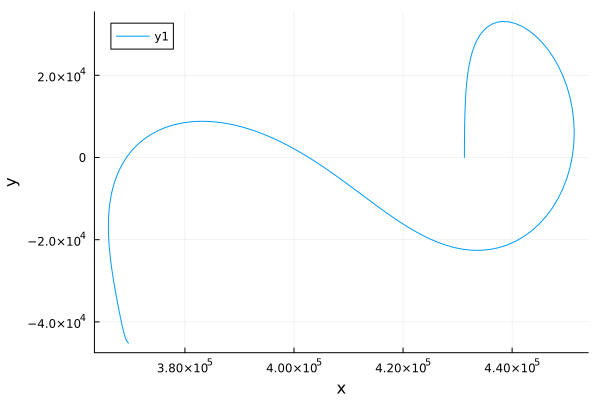

In [52]:
#this is if we rollout our dynamics with the stable initial condition
#almost periodic, can be fixed with a differential corrector
#plot(all_state_in[1,:], all_state_in[2,:], all_state_in[3,:], xlabel="x", ylabel="y", zlabel="z")

plot(all_state_in[1,:], all_state_in[2,:], xlabel="x", ylabel="y")

In [53]:
#fix with a single shooting differential corrector
function differential_corrector(x_0_stm, Tp)
    
    #this is the final time it converges to
    T_f = 0

    #Iterate to bring the δx at T/2 to the desired state
    max_iters = 1000

    #keep z0 fixed and change only x0 and y_dot_0
    for i=1:max_iters
    #for i=1:100

        solution = diff_solve(x_0_stm, Tp)

        #this is the state, STM, and time when y crosses the XZ plane 
        all_state, stm, sol_t = get_state_stm(solution)

        #display(stm)

        T2_state = all_state[:,end]

        #T2_state -> x,y,z, xdot, ydot, zdot
        #desired xdot an xzdot
        xz_d = [0, 0]

        rv = T2_state[1:6]

        rv_dot = three_body_prob_dynamics_scaled(rv)

        #desired state subtracted by state at t/2
        δxz = xz_d - [T2_state[4], T2_state[6]]

        #subset of the state transition matrix

        #all 6 variables 
        #stm_s = [stm[4,1] stm[4,3] stm[4,5]; stm[6,1] stm[6,3] stm[6,5]]

        #to change x and ydot 

        #keep z0 constant
        #stm_s = [stm[4,1] stm[4,5]; stm[6,1] stm[6,5]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,5]]

        #keep x0 constant
        stm_s = [stm[4,3, end] stm[4,5,end]; stm[6,3,end] stm[6,5,end]]
        dy = [rv_dot[4]; rv_dot[6]]*[stm[2,3,end] stm[2,5,end]]


        println("this is stm s: ")
        println(stm_s)


        #keep y0 constant
        #stm_s = [stm[4,1] stm[4,3]; stm[6,1] stm[6,3]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,3]]


        delta_x0 = (stm_s - dy/rv_dot[2])\δxz
        

        #println("THIS IS CONDITION NUMBER")
        #println(cond((stm_s - dy/rv_dot[2])))

        #delta_x0 = stm_s\δxz

        #update the initial state

        #x_0_stm[1] = x_0_stm[1] + delta_x0[1]
        x_0_stm[3] = x_0_stm[3] + delta_x0[1]
        x_0_stm[5] = x_0_stm[5] + delta_x0[2]

        #x_0_stm[1:6] = x_0_stm[1:6] + delta
        #when delta is below a set tolerance we are done

        println("residual: ", δxz)
        
        #loosen up the tolerance bc of the scaling of the problem
        if norm(δxz) < 1e-6

            #this is the total time, but we use it to ensure we have enough time to find where
            #y crosses the xz plane
            #print("this is sol t: ", sol_t)
            #updating time
                    
            T_f = sol_t[end]*2
            break
        end

    end
    
    corrected_solution = dynamics_integrate(x_0_stm, T_f)

    all_state_final, stm_final, sol_t_final = get_state_stm(corrected_solution)
    
    return all_state_final, stm_final, sol_t_final, corrected_solution
    
end

differential_corrector (generic function with 1 method)

In [54]:
#run the differential corrector to get the corrected solution
all_state_final, stm_final, sol_t_final, full_solution = differential_corrector(x_0_stm, T_scaled)

this is stm s: 


[1.3335865618039342 15.093299008541404; -0.10311365449111344 -1.491446310119585]
residual: 

[1643.9520665946734, -191.49882013184757]
this is stm s: 
[1.3706447493320473 13.41781462922589; -0.16402996578362267 -1.4803913910201687]
residual: [2.50640377938576, 35.41406163738534]
this is stm s: 
[0.9337746142402533 13.137080812325237; -0.08735682579349484 -0.9909221915754852]
residual: [-495.1172851568247, 60.68877908842731]
this is stm s: 
[0.8556943971835639 13.593143584694735; -0.06268457101812448 -0.9173447227620954]
residual: [-24.37546876993494, 8.50685424720485]
this is stm s: 
[0.6563014636768186 13.56401689335884; -0.038674523978709414 -0.7009728920039245]
residual: [-110.46814192446912, 9.54009309010716]
this is stm s: 
[0.5915487043065402 13.667055607582263; -0.029368083679226928 -0.6329492515766819]
residual: [-13.136469711447523, 1.7580358490853736]
this is stm s: 
[0.5200688568499974 13.678810072379951; -0.022594967500310974 -0.5562003101218614]
residual: [-14.472588166878632, 1.0122264537249142]
this is stm s: 
[0.49737561637211425 13.694531973059444; -0.02031731


[0.4907755916301844 13.696979763415966; -0.019725297260002297 -0.5249603759759689]
residual: [0.00010115294184219924, 3.78624364506784e-6]
this is stm s: 
[0.490774328579286 13.696980522999057; -0.019725193891261626 -0.5249591022728256]
residual: [-0.00010840135247014187, -4.056172106837442e-6]
this is stm s: 
[0.49077572097929956 13.696980724776612; -0.019725309124558936 -0.5249606255768108]
residual: [4.0602026942756594e-5, 1.5196958162793624e-6]
this is stm s: 
[0.4907751859338917 13.696980325514682; -0.019725263833096935 -0.5249600103081522]
residual: [-4.491641912241997e-5, -1.6801875776502769e-6]
this is stm s: 
[0.4907757716004738 13.696980595307455; -0.01972531352404484 -0.5249606611331865]
residual: [8.95029402409035e-5, 3.3480900212831964e-6]
this is stm s: 
[0.49077461412515394 13.696980200769895; -0.019725217935094807 -0.5249593634588122]
residual: [2.5252954553504204e-5, 9.458764132468768e-7]
this is stm s: 
[0.49077426347438347 13.696979500597237; -0.01972518747142795 -0


[0.4907748456947217 13.696980690439819; -0.019725236893631634 -0.5249596775523576]
residual: [-5.227632212883458e-5, -1.9555055820348197e-6]
this is stm s: 
[0.4907754434758553 13.696978937563797; -0.019725282542701283 -0.5249601363630094]
residual: [2.526325674966117e-5, 9.445346270878232e-7]
this is stm s: 
[0.490775121492687 13.696978937066609; -0.019725256327132037 -0.5249597851333317]
residual: [1.9801600011476456e-5, 7.422629668894696e-7]
this is stm s: 
[0.4907748675423388 13.696978913576983; -0.019725235368126755 -0.5249595081709016]
residual: [-4.346841780775944e-6, -1.6330339089233627e-7]
this is stm s: 
[0.490774925844258 13.6969789895646; -0.019725240137930464 -0.5249595815084275]
residual: [-1.60204148731252e-5, -6.00318410863837e-7]
this is stm s: 
[0.4907751336843618 13.696979056174584; -0.019725257706975443 -0.5249598097916055]
residual: [3.062028147907081e-5, 1.147433390467218e-6]
this is stm s: 
[0.4907747388181307 13.696978974237787; -0.01972522477426334 -0.52495937

([431249.946141646 431249.94614368404 … 431250.3817559771 431249.9493668459; 0.0 2.11865931416171 … -974.2704382779812 -0.003851463980650329; … ; 15649.01638927097 15649.016351075303 … 15640.937642552299 15649.014948352466; 0.0 -0.09679750259452195 … 44.50368193205585 0.0001293855647662], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.74681260289577e-14 … 4.21449737713891e-9 1.5618013565683038e-14; -2.1789856876862402e-14 0.9999999976191183 … 0.0001353861009620931 7.747326020150754e-20; … ; -4.828381202874513e-10 -3.517173033319686e-5 … 0.9999999956810307 2.288957559459435e-15; 5.112447756761017e-6 1.0493422150552927e-10 … 1.6653222599682134e-14 0.9999999971499303;;; 1.0000000245547165 4.529417817983927e-13 … 1.6691269091577298e-8 1.2309520780151584e-13; -1.7173931605969936e-13 0.999999990570658 … 0.0002694299455112233 1.2151753729360987e-18; … ; -1.9122519702650388e-9 -6.999475781107277e-5 … 0.9999999828949762 1.8040687294144393

In [55]:
all_state_final

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

In [56]:
sol_t_final

131-element Vector{Float64}:
  0.0
  0.00013538610115700251
  0.00026942994704742514
  0.0004303715711435791
  0.0006830964153669305
  0.0009491675045592131
  0.001277070628775285
  0.0016106543976025993
  0.0019878701330316474
  0.0024459945807384777
  ⋮
 13.87688676653883
 14.013485059891314
 14.148023074242456
 14.28247964970406
 14.41397369914275
 14.543371472173106
 14.66737869572139
 14.789903469175059
 14.852171558441775

In [57]:
#stm_final

In [58]:
#Finding the unstable direction for the unstable manifold to encode as a constraint

#monodromy = stm_final[:,:,end]

In [59]:
all_state_final

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

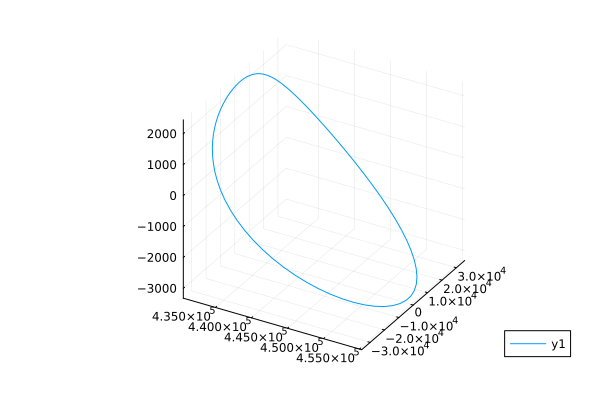

In [60]:
plot(all_state_final[1,:], all_state_final[2,:], all_state_final[3,:])

In [61]:
final_norm = all_state_final[:,end] - all_state_final[:,1]

6-element Vector{Float64}:
  0.00322519987821579
 -0.003851463980650329
  7.884718979767058e-5
  0.002199234649276377
 -0.001440918504158617
  0.0001293855647662

In [62]:
final_norm

6-element Vector{Float64}:
  0.00322519987821579
 -0.003851463980650329
  7.884718979767058e-5
  0.002199234649276377
 -0.001440918504158617
  0.0001293855647662

In [63]:
#Check when the orbit leave
periodic_initial_condition = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic = [periodic_initial_condition; Φ_0]

#integrate for 3.5 revs
solution_periodic = dynamics_integrate(x_0_stm, 3.5*sol_t_final[end])

all_state_lp, stm_in_lp, sol_t_in_lp = get_state_stm(solution_periodic)

([431249.946141646 431249.94614368404 … 554005.2428719949 557288.0105173714; 0.0 2.11865931416171 … -69190.52364549524 -75399.30097688234; … ; 15649.01638927097 15649.016351075303 … -46181.103118709194 -47985.92575257201; 0.0 -0.09679750259452195 … -761.2070424352357 -752.7103722662881], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.74681260289577e-14 … 4.21449737713891e-9 1.5618013565683038e-14; -2.1789856876862402e-14 0.9999999976191183 … 0.0001353861009620931 7.747326020150754e-20; … ; -4.828381202874513e-10 -3.517173033319686e-5 … 0.9999999956810307 2.288957559459435e-15; 5.112447756761017e-6 1.0493422150552927e-10 … 1.6653222599682134e-14 0.9999999971499303;;; 1.0000000245547165 4.529417817983927e-13 … 1.6691269091577298e-8 1.2309520780151584e-13; -1.7173931605969936e-13 0.999999990570658 … 0.0002694299455112233 1.2151753729360987e-18; … ; -1.9122519702650388e-9 -6.999475781107277e-5 … 0.9999999828949762 1.8040687294144393e

In [64]:
all_state_lp

6×333 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …       5.54005e5  557288.0
     0.0           2.11866        4.21631       -69190.5        -75399.3
  2286.77       2286.77        2286.77           -2892.26        -2992.08
     0.0           0.0301068      0.0599152      25052.3         24725.6
 15649.0       15649.0        15649.0           -46181.1        -47985.9
     0.0          -0.0967975     -0.192635   …    -761.207        -752.71

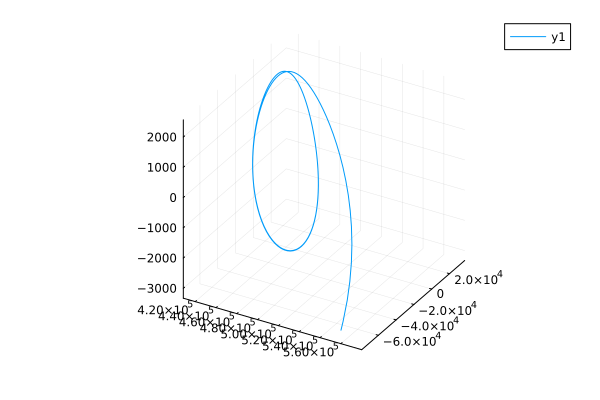

In [65]:
plot(all_state_lp[1,:], all_state_lp[2,:], all_state_lp[3,:], aspectratio=true)

In [66]:
#as seen above, after about 3.5 periods it begins to diverge from the periodic orbit 
#will formulate as a convex optimiztion problem to generate the station keeping 
#maneuvers

In [67]:
#this is the continuous dynamics
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), all_state_final[:,1])

In [68]:
#this is including the slack variable in the control vector
#B = [zeros(3,4); I][1:6, :]

In [69]:
nx = 6 #number of states
nu = 3 #number of controls 

3

In [70]:
#this is the A tilde to get the discretized dynamics
#Ã = [AL2 B; zeros(4,10)]

#this is the number of knot points in one horizon
N_period = 41  #40 knot points per period per period

N_h = 82 #horizon 2 periods

#this is the time step. (period T is already scaled). for 1 period
# 100 poi
Δt = (sol_t_final[end]/(N_period-1))

0.3713042889610444

In [71]:
all_state_final[:,1]

6-element Vector{Float64}:
 431249.946141646
      0.0
   2286.769716989665
      0.0
  15649.01638927097
      0.0

In [72]:
# custom_position_scale = norm(all_state_final[:,1])
# custom_time_scale = sol_t_final[end]
# custom_velocity_scale = custom_position_scale/custom_time_scale

In [73]:
# function get_reference(i,N)
    
#     reference = zeros(nx, N)

#     for k=1:N

#         reference[:,k] = full_solution(horizon[i:end]).u[k][1:6]
        
#     end

#     return reference
    
# end

In [74]:
#Ad = H[1:nx, 1:nx]
#Bd = H[1:nx, nx+1:end]

In [75]:
#umin = 0.5
#umax = 1

In [76]:
#N (number of knot points) 6x6 discrete dynamics jacobians

#this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 41] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [77]:
T_corrected = sol_t_final[end]

14.852171558441775

In [78]:
horizon = LinRange(0, T_corrected, N_period)

41-element LinRange{Float64, Int64}:
 0.0, 0.371304, 0.742609, 1.11391, …, 13.7383, 14.1096, 14.4809, 14.8522

In [79]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0


In [80]:
horizon

41-element LinRange{Float64, Int64}:
 0.0, 0.371304, 0.742609, 1.11391, …, 13.7383, 14.1096, 14.4809, 14.8522

In [81]:
full_solution(horizon).u[1][7:end]

36-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 ⋮
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [82]:
#get the reference trajectory
reference_trajectory = zeros(nx, N_period)

for k=1:N_period

    reference_trajectory[:,k] = full_solution(horizon).u[k][1:6]
    
    #save the reference state transition matrices at the dedicated timesteps
    
    stm_times[:,:,k] = reshape(full_solution(horizon).u[k][7:end], (6,6)) 
        
end

In [83]:
#monodromy is the stm at the end of the periodic orbit
monodromy_eigen = eigen(stm_times[:,:,end])

stable_dir = real(monodromy_eigen.vectors[:,1])
unstable_dir = real(monodromy_eigen.vectors[:,end])
#find the eigen values of the monodromy

6-element Vector{Float64}:
  0.5935997677778411
 -0.6423215383474878
  0.013967734765510597
  0.40497424701619056
 -0.265176994172325
  0.023329819329140137

In [84]:
#save the unstable directions in a matrix
unstable_directions = zeros(6,N_period)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [85]:
#the unstable directions are then the stm at the timestep multiplied by the unstable direction found by the monodromy

for k = 1:N_period
    
    unstable_directions[:,k] = (stm_times[:,:,k]*unstable_dir)/norm(stm_times[:,:,k]*unstable_dir)
    
end

In [86]:
#unstable directions for the unstable manifolds along the orbit
unstable_directions

6×41 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642322   -0.611253   -0.574696   -0.534157      -0.666939    -0.642322
  0.0139677   0.0196798   0.024741    0.028827       0.00797906   0.0139677
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233298   0.0246805   0.0244821   0.0229326  …   0.0205333    0.0233298

In [87]:
#[unstable_directions[1:3, 1]; zeros(3)]

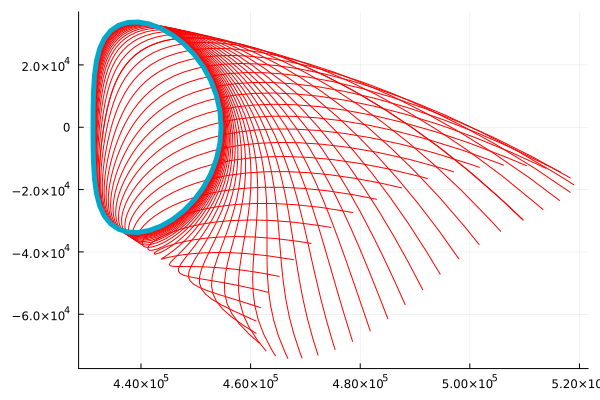

In [88]:
#plot the manifolds
#+ manifold to the right
# - manifold to the left
epz = 3
#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit")

plot(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Orbit")


for i=1:41

    #initial_state = reference_trajectory[:,i] + epz.*unstable_directions[:,i]

    initial_state = reference_trajectory[:,i] + epz.*[unstable_directions[1:3,i];zeros(3)]

    #initial_state = reference_trajectory[:,i] - epz.*unstable_directions[:,i]

    inv_manifold = just_dynamics_integrate(initial_state, 1.5*sol_t_final[end])

    all_state_m = get_state(inv_manifold)

    #plot!(all_state_m[1,:], all_state_m[2,:], all_state_m[3,:], color="red", legend=false)

    plot!(all_state_m[1,:], all_state_m[2,:], color="red", legend=false)

end

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit", linewidth = 5)

plot!(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Orbit", linewidth = 5)


In [89]:
#two orbits worth of data
unstable_constraint = cat(unstable_directions, unstable_directions, dims=2)

6×82 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642322   -0.611253   -0.574696   -0.534157      -0.666939    -0.642322
  0.0139677   0.0196798   0.024741    0.028827       0.00797906   0.0139677
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233298   0.0246805   0.0244821   0.0229326  …   0.0205333    0.0233298

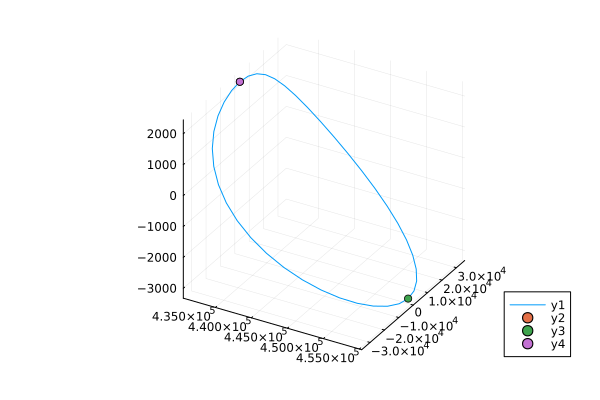

In [90]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])
scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])
scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

In [91]:
#obtain the reference trajectory at the knot points that we made up

#reference_trajectory = get_reference(1,N_period)

In [92]:
#goal is to have a look ahead of 2 orbits and apply an MPC controller 

#3 periods worth of data (just using the same orbit over the 3 periods)
#reference_trajectory_all = [reference_trajectory reference_trajectory reference_trajectory]

In [94]:
for i=1:N_period

    #get the discrete dynamics jacobians for the entire reference trajectory along the knot points

    Ak = ForwardDiff.jacobian(x-> three_body_prob_dynamics_scaled(x), reference_trajectory[:,i])

    #this is including the slack variable in the control vector (this is control on accelerations/thrust)
    Bk = [zeros(3,3); I]

    #this is the A tilde to get the discretized dynamics
    Ãk = [Ak Bk; zeros(3,9)]

    H = exp(Ãk*Δt)

    all_Ad[:,:,i] = H[1:nx, 1:nx]

    all_Bd[:,:,i] = H[1:nx, nx+1:end]
    
    
end

In [95]:
all_Bd

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  0.0693027   0.003929     2.99276e-5
 -0.003929    0.0685605   -1.02094e-6
  2.99276e-5  1.02094e-6   0.0686875
  0.375288    0.031775     0.00032252
 -0.031775    0.367288    -1.37462e-5
  0.00032252  1.37462e-5   0.368657

[:, :, 2] =
  0.0692859    0.00400204  2.84579e-5
 -0.00385568   0.068573    2.2015e-6
  2.82416e-5   4.13578e-6  0.0686917
  0.375106     0.0325618   0.000306968
 -0.0309843    0.367423    2.11186e-5
  0.000304056  4.71621e-5  0.368702

[:, :, 3] =
  0.0692416    0.00405954  2.43808e-5
 -0.00379737   0.0686054   4.4728e-6
  2.40191e-5   6.12405e-6  0.0687034
  0.374629     0.0331804   0.000263217
 -0.0303548    0.367772    4.59693e-5
  0.000258348  6.82021e-5  0.368828

;;; … 

[:, :, 39] =
  0.0692416     0.00379737   2.40191e-5
 -0.00405954    0.0686054   -6.12405e-6
  2.43808e-5   -4.4728e-6    0.0687034
  0.374629      0.0303548    0.000258348
 -0.0331804     0.367772    -6.82021e-5
  0.000263217  -4.59693e-5   0.368828



In [96]:
#concatenate jacobians for two periods

all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

6×3×82 Array{Float64, 3}:
[:, :, 1] =
  0.0693027   0.003929     2.99276e-5
 -0.003929    0.0685605   -1.02094e-6
  2.99276e-5  1.02094e-6   0.0686875
  0.375288    0.031775     0.00032252
 -0.031775    0.367288    -1.37462e-5
  0.00032252  1.37462e-5   0.368657

[:, :, 2] =
  0.0692859    0.00400204  2.84579e-5
 -0.00385568   0.068573    2.2015e-6
  2.82416e-5   4.13578e-6  0.0686917
  0.375106     0.0325618   0.000306968
 -0.0309843    0.367423    2.11186e-5
  0.000304056  4.71621e-5  0.368702

[:, :, 3] =
  0.0692416    0.00405954  2.43808e-5
 -0.00379737   0.0686054   4.4728e-6
  2.40191e-5   6.12405e-6  0.0687034
  0.374629     0.0331804   0.000263217
 -0.0303548    0.367772    4.59693e-5
  0.000258348  6.82021e-5  0.368828

;;; … 

[:, :, 80] =
  0.0692416     0.00379737   2.40191e-5
 -0.00405954    0.0686054   -6.12405e-6
  2.43808e-5   -4.4728e-6    0.0687034
  0.374629      0.0303548    0.000258348
 -0.0331804     0.367772    -6.82021e-5
  0.000263217  -4.59693e-5   0.368828



In [97]:
N_period

41

In [98]:
num_revs = 10

10

In [99]:
#1 revolution is 14 days
#T*time_scale/60/60/24

In [100]:
#compute backward ricatti recursion

#cost to go matrices
#P = zeros((6,6,N_period*num_revs)) #size state x state (6x6) 
#K = zeros((3,6,N_period*num_revs)) #size control x state (3x6)

#cost to go matrices for 16 revs
P = zeros((6,6,N_period*16)) #size state x state (6x6) 
K = zeros((3,6,N_period*16)) #size control x state (3x6)


#state cost weight matrix
Q = 1.0*Matrix(I,6,6).*1e-3

#terminal cost weight matrix
Qf = 1.0*Matrix(I,6,6).*1e-3

#control cost weight matrix
R = 1.0*Matrix(I,3,3).*1e3

3×3 Matrix{Float64}:
 1000.0     0.0     0.0
    0.0  1000.0     0.0
    0.0     0.0  1000.0

In [101]:
P

6×6×656 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 654] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 655] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0

In [102]:
1:(N_period*num_revs) - 1

1:409

In [103]:
all_Ad_rev = all_Ad

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  1.04689     -0.00102071   0.0026077    …  0.031775      0.00032252
 -0.00265804   0.982189    -0.000148049     0.367288     -1.37462e-5
  0.00261402  -2.65229e-7   0.97864         1.37462e-5    0.368657
  0.253898    -0.00825477   0.0140713       0.17156       0.0026077
 -0.0214966   -0.0954172   -0.00119561      0.967577     -0.000148049
  0.0141394   -3.57109e-6  -0.114634     …  0.000148049   0.97864

[:, :, 2] =
 1.04578      0.00542008    0.0024858    …  0.0325618    0.000306968
 0.0038039    0.982914      0.000135678     0.367423     2.11186e-5
 0.00247613   0.000276349   0.979008        4.71621e-5   0.368702
 0.248835     0.0266862     0.0134547       0.177917     0.0024858
 0.0136158   -0.0925025     0.00035478      0.968665     0.000135678
 0.0133928    0.00149128   -0.11267      …  0.000416172  0.979008

[:, :, 3] =
 1.04219      0.0106272     0.00213455   …  0.0331804    0.000263217
 0.00906912   0.985444      0.000341613     0.367772 

In [104]:
all_Ad_4 = cat(all_Ad_1, all_Ad_1, dims=3)
all_Bd_4 = cat(all_Bd_1, all_Bd_1, dims=3)

all_Ad_8 = cat(all_Ad_4, all_Ad_4, dims=3)
all_Bd_8 = cat(all_Bd_4, all_Bd_4, dims=3)

all_Ad_16 = cat(all_Ad_8, all_Ad_8, dims=3)
all_Bd_16 = cat(all_Bd_8, all_Bd_8, dims=3)

6×3×656 Array{Float64, 3}:
[:, :, 1] =
  0.0693027   0.003929     2.99276e-5
 -0.003929    0.0685605   -1.02094e-6
  2.99276e-5  1.02094e-6   0.0686875
  0.375288    0.031775     0.00032252
 -0.031775    0.367288    -1.37462e-5
  0.00032252  1.37462e-5   0.368657

[:, :, 2] =
  0.0692859    0.00400204  2.84579e-5
 -0.00385568   0.068573    2.2015e-6
  2.82416e-5   4.13578e-6  0.0686917
  0.375106     0.0325618   0.000306968
 -0.0309843    0.367423    2.11186e-5
  0.000304056  4.71621e-5  0.368702

[:, :, 3] =
  0.0692416    0.00405954  2.43808e-5
 -0.00379737   0.0686054   4.4728e-6
  2.40191e-5   6.12405e-6  0.0687034
  0.374629     0.0331804   0.000263217
 -0.0303548    0.367772    4.59693e-5
  0.000258348  6.82021e-5  0.368828

;;; … 

[:, :, 654] =
  0.0692416     0.00379737   2.40191e-5
 -0.00405954    0.0686054   -6.12405e-6
  2.43808e-5   -4.4728e-6    0.0687034
  0.374629      0.0303548    0.000258348
 -0.0331804     0.367772    -6.82021e-5
  0.000263217  -4.59693e-5   0.368828

In [105]:
for i = 1:num_revs
    all_Ad_rev = (all_Ad_rev, all_Ad, dims=3)
end

In [106]:
# P[:,:,end] = Qf

# for k = reverse(1:(N_period*num_revs) - 1)
    
#     K[:,:,k] = (R + all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k])\(all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:, k]) # ricatti recursion for both A and B matrices changing
#     P[:,:,k] = Q + all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:,k] - all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k]*K[:,:,k]
 
# end 

In [107]:
#Ricatti recursion over 2 periods
P[:,:,end] = Qf

for k = reverse(1:N_period*16-1)
    #println(k)    
    K[:,:,k] = (R + all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k])\(all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:, k]) # ricatti recursion for both A and B matrices changing
    P[:,:,k] = Q + all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:,k] - all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k]*K[:,:,k]
        
end

In [108]:
P

6×6×656 Array{Float64, 3}:
[:, :, 1] =
 1901.15    -95.4175   66.267     1655.93    1683.99    45.3411
  -95.4175    8.13059  -2.44069    -76.1513   -87.77    -2.49275
   66.267    -2.44069   5.60468     59.7065    58.0446  -0.869069
 1655.93    -76.1513   59.7065    1457.06    1459.72    38.8989
 1683.99    -87.77     58.0446    1459.72    1495.34    40.2045
   45.3411   -2.49275  -0.869069    38.8989    40.2045   3.57316

[:, :, 2] =
 1851.91    65.6731    59.7923   1553.01    1742.13    28.96
   65.6731   4.9881     2.8534     62.1274    58.2714   0.563309
   59.7923   2.8534     4.54661    52.2036    55.4462  -2.19796
 1553.01    62.1274    52.2036   1321.44    1451.2     22.8802
 1742.13    58.2714    55.4462   1451.2     1644.11    27.6338
   28.96     0.563309  -2.19796    22.8802    27.6338   5.04139

[:, :, 3] =
 1728.01    192.384     48.6025   1431.37     1732.55    12.3342
  192.384    23.2195     5.93685   165.73      189.617    0.775495
   48.6025    5.93685    3.21884   

In [109]:
P[:,:,1]

6×6 Matrix{Float64}:
 1901.15    -95.4175   66.267     1655.93    1683.99    45.3411
  -95.4175    8.13059  -2.44069    -76.1513   -87.77    -2.49275
   66.267    -2.44069   5.60468     59.7065    58.0446  -0.869069
 1655.93    -76.1513   59.7065    1457.06    1459.72    38.8989
 1683.99    -87.77     58.0446    1459.72    1495.34    40.2045
   45.3411   -2.49275  -0.869069    38.8989    40.2045   3.57316

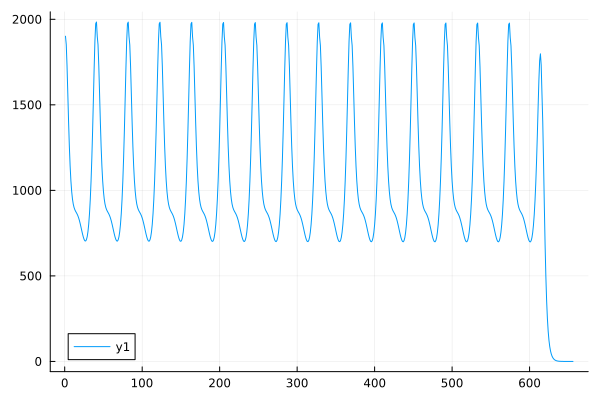

In [110]:
plot(P[1,1,:])
#plot(P[2,2,:])
#plot(P[3,3,:])
#plot(P[4,4,:])
#plot(P[5,5,:])
#plot(P[6,6,:])

In [111]:
#cost to go converges and is periodic! will get one orbit of the cost to go to make a constraint
V = P[:,:,1:41]

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 1901.15    -95.4175   66.267     1655.93    1683.99    45.3411
  -95.4175    8.13059  -2.44069    -76.1513   -87.77    -2.49275
   66.267    -2.44069   5.60468     59.7065    58.0446  -0.869069
 1655.93    -76.1513   59.7065    1457.06    1459.72    38.8989
 1683.99    -87.77     58.0446    1459.72    1495.34    40.2045
   45.3411   -2.49275  -0.869069    38.8989    40.2045   3.57316

[:, :, 2] =
 1851.91    65.6731    59.7923   1553.01    1742.13    28.96
   65.6731   4.9881     2.8534     62.1274    58.2714   0.563309
   59.7923   2.8534     4.54661    52.2036    55.4462  -2.19796
 1553.01    62.1274    52.2036   1321.44    1451.2     22.8802
 1742.13    58.2714    55.4462   1451.2     1644.11    27.6338
   28.96     0.563309  -2.19796    22.8802    27.6338   5.04139

[:, :, 3] =
 1728.01    192.384     48.6025   1431.37     1732.55    12.3342
  192.384    23.2195     5.93685   165.73      189.617    0.775495
   48.6025    5.93685    3.21884    

In [112]:
#cost to go matrices for 2 orbits worth of data
V_2orbits = cat(V, V, dims=3)

6×6×82 Array{Float64, 3}:
[:, :, 1] =
 1901.15    -95.4175   66.267     1655.93    1683.99    45.3411
  -95.4175    8.13059  -2.44069    -76.1513   -87.77    -2.49275
   66.267    -2.44069   5.60468     59.7065    58.0446  -0.869069
 1655.93    -76.1513   59.7065    1457.06    1459.72    38.8989
 1683.99    -87.77     58.0446    1459.72    1495.34    40.2045
   45.3411   -2.49275  -0.869069    38.8989    40.2045   3.57316

[:, :, 2] =
 1851.91    65.6731    59.7923   1553.01    1742.13    28.96
   65.6731   4.9881     2.8534     62.1274    58.2714   0.563309
   59.7923   2.8534     4.54661    52.2036    55.4462  -2.19796
 1553.01    62.1274    52.2036   1321.44    1451.2     22.8802
 1742.13    58.2714    55.4462   1451.2     1644.11    27.6338
   28.96     0.563309  -2.19796    22.8802    27.6338   5.04139

[:, :, 3] =
 1728.01    192.384     48.6025   1431.37     1732.55    12.3342
  192.384    23.2195     5.93685   165.73      189.617    0.775495
   48.6025    5.93685    3.21884    

In [113]:
V_first = V_2orbits[:,:,1]

6×6 Matrix{Float64}:
 1901.15    -95.4175   66.267     1655.93    1683.99    45.3411
  -95.4175    8.13059  -2.44069    -76.1513   -87.77    -2.49275
   66.267    -2.44069   5.60468     59.7065    58.0446  -0.869069
 1655.93    -76.1513   59.7065    1457.06    1459.72    38.8989
 1683.99    -87.77     58.0446    1459.72    1495.34    40.2045
   45.3411   -2.49275  -0.869069    38.8989    40.2045   3.57316

In [114]:
V_first'

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
 1901.15    -95.4175   66.267     1655.93    1683.99    45.3411
  -95.4175    8.13059  -2.44069    -76.1513   -87.77    -2.49275
   66.267    -2.44069   5.60468     59.7065    58.0446  -0.869069
 1655.93    -76.1513   59.7065    1457.06    1459.72    38.8989
 1683.99    -87.77     58.0446    1459.72    1495.34    40.2045
   45.3411   -2.49275  -0.869069    38.8989    40.2045   3.57316

In [115]:
difference = V_first - V_first'

6×6 Matrix{Float64}:
 0.0          -2.25953e-12  -4.9738e-13   …  -1.59162e-12  -2.98428e-13
 2.25953e-12   0.0           3.90799e-14     -8.95284e-13  -3.5616e-13
 4.9738e-13   -3.90799e-14   0.0             -2.34479e-13  -2.37477e-13
 2.04636e-12  -3.80851e-12  -8.31335e-13     -3.41061e-12  -8.02913e-13
 1.59162e-12   8.95284e-13   2.34479e-13      0.0          -2.55795e-13
 2.98428e-13   3.5616e-13    2.37477e-13  …   2.55795e-13   0.0

In [116]:
difference2 = V_2orbits[:,:,2] - V_2orbits[:,:,2]'

6×6 Matrix{Float64}:
 0.0          -2.089e-12    -4.76064e-13  …  -1.36424e-12  -1.63425e-13
 2.089e-12     0.0          -1.24345e-14     -9.80549e-13  -3.75255e-13
 4.76064e-13   1.24345e-14   0.0             -1.84741e-13  -2.3137e-13
 2.27374e-12  -3.71614e-12  -8.66862e-13     -3.41061e-12  -6.71463e-13
 1.36424e-12   9.80549e-13   1.84741e-13      0.0          -2.70006e-13
 1.63425e-13   3.75255e-13   2.3137e-13   …   2.70006e-13   0.0

In [117]:
symmetric_v1 = (V_first + V_first')/2

6×6 Matrix{Float64}:
 1901.15    -95.4175   66.267     1655.93    1683.99    45.3411
  -95.4175    8.13059  -2.44069    -76.1513   -87.77    -2.49275
   66.267    -2.44069   5.60468     59.7065    58.0446  -0.869069
 1655.93    -76.1513   59.7065    1457.06    1459.72    38.8989
 1683.99    -87.77     58.0446    1459.72    1495.34    40.2045
   45.3411   -2.49275  -0.869069    38.8989    40.2045   3.57316

In [118]:
#needed for the quadratic constraint
invsymmetricv1 = inv(symmetric_v1)

6×6 Matrix{Float64}:
 127.25     125.387     3.76016  -85.4008   -52.5928   -4.85329
 125.387    130.203     3.40314  -86.0977   -49.5145   -4.99349
   3.76016    3.40314   1.45018   -2.54699   -1.63549   1.14268
 -85.4008   -86.0977   -2.54699   57.9254    34.5882    3.21565
 -52.5928   -49.5145   -1.63549   34.5882    22.5693    1.94007
  -4.85329   -4.99349   1.14268    3.21565    1.94007   1.82312

In [119]:
invsymmetricv1 - invsymmetricv1'

6×6 Matrix{Float64}:
  0.0           6.55547e-11  -6.10623e-13  …   2.37392e-11  -4.22773e-13
 -6.55547e-11   0.0          -2.55396e-12      5.04983e-11   2.06857e-12
  6.10623e-13   2.55396e-12   0.0              4.52527e-13  -3.57492e-14
  2.03357e-11  -2.39595e-11   1.01386e-12     -2.43432e-11  -4.90274e-13
 -2.37392e-11  -5.04983e-11  -4.52527e-13      0.0           1.07736e-12
  4.22773e-13  -2.06857e-12   3.57492e-14  …  -1.07736e-12   0.0

In [120]:
display(V_first)

6×6 Matrix{Float64}:
 1901.15    -95.4175   66.267     1655.93    1683.99    45.3411
  -95.4175    8.13059  -2.44069    -76.1513   -87.77    -2.49275
   66.267    -2.44069   5.60468     59.7065    58.0446  -0.869069
 1655.93    -76.1513   59.7065    1457.06    1459.72    38.8989
 1683.99    -87.77     58.0446    1459.72    1495.34    40.2045
   45.3411   -2.49275  -0.869069    38.8989    40.2045   3.57316

In [121]:
#
#x_initial_ref'*inv(V_first)*x_initial_ref

In [122]:
#far_deviation = [1, 0, 1, 0, 1, 0]

In [123]:
#cost to go for this far deviation
#far_deviation'*inv(V_first)*far_deviation

In [124]:
#get the initial delta x
#this is some noise on the reference trajectory

#some arbitrary deviation from the reference trajectory
#x_initial_ref = [1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5]

#this is working
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#this is working. Pretty far deviation in x = 385 km, and vy off by ~1e-3 km/s
#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]


#off by 385 km meters and ~1 mm/s

#x_initial_ref = [1e-3, 0, 0, 0, 1e-6, 0]


#try a small deviation
x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

x_initial_ref_scaled = [x_initial_ref[1:3]*L; x_initial_ref[4:6]*V_]

#ensure that the initial deviation is in the unstable manifold direction
#x_initial_ref = [1e-9, -1e-9, 1e-9, 1e-9, -1e-9, 1e-9]

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [125]:
#concatenate unstable directions for 2 orbits

unstable_directions_2 = cat(unstable_directions, unstable_directions, dims=2)

6×82 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642322   -0.611253   -0.574696   -0.534157      -0.666939    -0.642322
  0.0139677   0.0196798   0.024741    0.028827       0.00797906   0.0139677
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233298   0.0246805   0.0244821   0.0229326  …   0.0205333    0.0233298

In [126]:
V_2orbits

6×6×82 Array{Float64, 3}:
[:, :, 1] =
 1901.15    -95.4175   66.267     1655.93    1683.99    45.3411
  -95.4175    8.13059  -2.44069    -76.1513   -87.77    -2.49275
   66.267    -2.44069   5.60468     59.7065    58.0446  -0.869069
 1655.93    -76.1513   59.7065    1457.06    1459.72    38.8989
 1683.99    -87.77     58.0446    1459.72    1495.34    40.2045
   45.3411   -2.49275  -0.869069    38.8989    40.2045   3.57316

[:, :, 2] =
 1851.91    65.6731    59.7923   1553.01    1742.13    28.96
   65.6731   4.9881     2.8534     62.1274    58.2714   0.563309
   59.7923   2.8534     4.54661    52.2036    55.4462  -2.19796
 1553.01    62.1274    52.2036   1321.44    1451.2     22.8802
 1742.13    58.2714    55.4462   1451.2     1644.11    27.6338
   28.96     0.563309  -2.19796    22.8802    27.6338   5.04139

[:, :, 3] =
 1728.01    192.384     48.6025   1431.37     1732.55    12.3342
  192.384    23.2195     5.93685   165.73      189.617    0.775495
   48.6025    5.93685    3.21884    

In [127]:
#cost to go level set
epsilon = 1

umax = 0.025

0.025

In [128]:
tube_pose_r = 1e-5
tube_vel_r = 1e-5

1.0e-5

In [129]:
x_initial_ref[:,1]

6-element Vector{Float64}:
 1.0e-9
 0.0
 0.0
 0.0
 1.0e-9
 0.0

In [130]:
# c_test= unstable_directions[:,1]/tan(pi/6)

# manifold_constraint_test = norm(x_initial_ref[:,1]) - c_test'*(x_initial_ref[:,1])

In [131]:
# dot(x_initial_ref[:,1], unstable_directions[:,1])

In [132]:
# dot(reference_trajectory[:,1] + x_initial_ref, unstable_directions[:,1])

In [133]:
# test = (reference_trajectory[:,1] + x_initial_ref)/norm(reference_trajectory[:,1] + x_initial_ref)

In [134]:
# dot(test, unstable_directions[:,1])

In [135]:
# L

In [136]:
# dot(x_initial_ref, unstable_directions[:,1])

In [137]:
all_Ad

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  1.04689     -0.00102071   0.0026077    …  0.031775      0.00032252
 -0.00265804   0.982189    -0.000148049     0.367288     -1.37462e-5
  0.00261402  -2.65229e-7   0.97864         1.37462e-5    0.368657
  0.253898    -0.00825477   0.0140713       0.17156       0.0026077
 -0.0214966   -0.0954172   -0.00119561      0.967577     -0.000148049
  0.0141394   -3.57109e-6  -0.114634     …  0.000148049   0.97864

[:, :, 2] =
 1.04578      0.00542008    0.0024858    …  0.0325618    0.000306968
 0.0038039    0.982914      0.000135678     0.367423     2.11186e-5
 0.00247613   0.000276349   0.979008        4.71621e-5   0.368702
 0.248835     0.0266862     0.0134547       0.177917     0.0024858
 0.0136158   -0.0925025     0.00035478      0.968665     0.000135678
 0.0133928    0.00149128   -0.11267      …  0.000416172  0.979008

[:, :, 3] =
 1.04219      0.0106272     0.00213455   …  0.0331804    0.000263217
 0.00906912   0.985444      0.000341613     0.367772 

In [138]:
#formulate the problem at every solve

#BUG: should also be sending in the updated cost to go and unstable directions matrices as you go along the orbit

#pass in the initial condition, along with jacobians of the current reference trajectory 
function update_prob(x_initial_k, all_Ad_k, all_Bd_k, P_k, unstable_directions_k)
    
    #clear the constraints and decision variables every run
    #cons = 0
    #U = 0
    
    X = Variable(nx,N_h)
        
    U = Variable(nu, N_h-1)
    
    #initial state constraint
    cons = Constraint[X[:,1] == x_initial_k]

    #state constraints
    #Dynamics constraint (for the entire horizon)
    
    for k=1:(N_h-1)
        #these are the dynamics for delta x
        
        #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        
        push!(cons, X[:,k+1] == all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k])
    end
    
    #already propagating the deltas since we are linearizing the dynamics about the reference trajectories
    
#     for k=1:(N_h-1)        
#         #Box constraints on the deviation from the reference trajectory
                
#         push!(cons, X[1,k] <= xmax)
#         push!(cons, X[1,k] >= -xmax)
#         push!(cons, X[2,k] <= ymax)
#         push!(cons, X[2,k] >= -ymax)
#         push!(cons, X[3,k]<= zmax)
#         push!(cons, X[3,k] >= -zmax)
         
#     end
    
    
    #tube constraint
    #for k=2:(N_h-1) #this was there before and works
    #THIS WORKS
    # for k=2:N_h 
    #    push!(cons, norm(X[1:3,k],2) <= tube_pose_r)
    
    #    push!(cons, norm(X[4:6,k],2) <= tube_vel_r)
         
    # end
    
    
    # #cost to go constraint (working)
    # for k=2:N_h
        
    #    costtogo = P_k[:,:,k]
        
    #    costtogo_hermitian = (costtogo + costtogo')/2
        
    #    #relaxing bc of the manifold constraint
    #    ctg_constraint = quadform(X[:,k], costtogo_hermitian) <= epsilon
        
    #    push!(cons, ctg_constraint)
                
    # end
    
    #manifold constraint (useful)
    #the delta x needs to be normalized
    #exits to the left with the negative sending
    #this is what is used. for some reason it is being infeasbile in problem 2
   #for k=1:N_h
#     for k=2:N_h 
        
#       #this works the best. investigate why 
#       #manifold goes to the left.  (w no ctg constraint)
#       #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.5*norm(X[:,k]))
        
        
#       #testing  (working) 
#       #goes left with positive unstable direction
#       manifold_constraint = dot(X[:,k], 1*unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.1*norm(X[:,k]))

#       #push!(cons, manifold_constraint >= 0)

#       #trying out 
#       push!(cons, manifold_constraint > 0)

                
        
#    end

    # for k = 2:N_h
            
    #         #manifold goes to the right
    #         manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
    
    #         push!(cons, manifold_constraint > 0)
    
    # end

   #manifold glideslope constraint for the whole unstable direction

#    for k=2:N_h
#     for k=1:N_h

#         #works with pi/5 too
#         c = unstable_directions_k[:,k]/tan(pi/6)

#         manifold_constraint = norm(X[:,k]) - c'*(X[:,k])

#         push!(cons, manifold_constraint <= 0)

#    end

for k=2:N_h
        
    #works with pi/5 too
    c = unstable_directions_k[:,k]/tan(pi/8)
    #c = unstable_directions_k[:,k]/tan((pi/2) - deg2rad(60)

    manifold_constraint = norm(X[:,k]) - c'*X[:,k]

    push!(cons, manifold_constraint <= 0)

end

    
     
    #Controls Constraint
    
    # for k=1:(N_h-1)
        
    #   push!(cons, norm(U[1:3, k]) <= umax)

    # end
        
    #    push!(cons, U[1:3, k]> umin)
        
        
        #not working
        #σ = U[4,k]
        
        #convexified non convex constraint lower bound
        #push!(cons, umin <= σ)
        
        #convexified non convex constraint upper bound
        #push!(cons, σ <= umax)
        
        #convex upper bound on the thrust norm
        #push!(cons, norm(U[1:3,k]) <= σ)
        
        
        #upper bound
        #push!(cons, norm(U[1:3,k]) <= min(σ, umax))
        
        
    #end
    
    #print("done")
    
    return cons, X, U
        
end

update_prob (generic function with 1 method)

In [139]:
unstable_directions[:,1]

6-element Vector{Float64}:
  0.5935997677778412
 -0.642321538347488
  0.013967734765510598
  0.4049742470161906
 -0.26517699417232504
  0.02332981932914014

In [140]:
#create the optimization problem

function solve_opt(cons, X, U, N)
    
    #these are tuning parameters
    
    #controls how tight you are tracking the reference 
    #α = 1e3
    
    #controls how much control effort you want to use (high value = low control)
    #β = 1e6
    #β = [1e6, 1e6, 1e15]
    #β = [1e3, 1e3, 1e3]
    #works with 1
    #works good with 1e-4 on just tracking and 0 on controls
    #β = 0
    #α = 1e-5

    #testing
    β = 1e6
    α = 1

    
    #β = 1 #some of the revs are slow to solve and solution may be innacurate
    
    #the cost function (L1 norm on the cost and the tracking error)
    obj = 0
    
    #for k=1:N
    #    obj += α*norm(X[:,k], 1)
    #end
    
    
    #for a lyaponov orbit we want to stay in the x y plane, so we penalize z maneuvers heavily while 
    #allowing for x and y
    
    for k=1:N-1
        
       #obj += β[1]*abs(U[1,k])+β[2]*abs(U[2,k]) +β[3]*abs(U[3,k])  
        
       #obj += β*norm(U[:,k], 1)
        
        #use L2 norm
        
        #^2 doesn't work in Convex.jl. have to use quadform 
        #obj += β*(norm(U[:,k]))^2 + α*(norm(X[:,k]))^2

        #obj = (norm(X[:,k]))^2

        
        #Px = 1.0*Matrix(I,6,6)

        #Pu = 1.0*Matrix(I,3,3)  
        #this gives the expected behavior with the manifolds but it does not minimize for cost
        #obj += quadform(X[:,k], Px; assume_psd=false)

        #obj += quadform(U[:,k], Pu; assume_psd=false)
        
        #this cost function works good, but gives continous thrust 
        #obj += quadform(U[:,k], Pu; assume_psd=false) + quadform(X[:,k], Px; assume_psd=false)
        #obj += β*norm(U[:,k], 1) + α*norm(X[:,k], 1)
        obj += norm(U[:,k], 1) + 1e-2*norm(X[:,k], 1) 
        #obj += norm(X[:,k], 2) 
        
    end
            
    
    prob = minimize(obj, cons);
    
    #this objective function is working
    #prob = minimize(norm(X[:,end]), cons);
    
    #this works too
    #prob = minimize(quadform(X[:,end], Q), cons)
    
    #print("mosek solving")
    #solve the problem with Mosek
    Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver=true);
    
    #solve the problem with ECOS
    #Convex.solve!(prob, ()-> ECOS.Optimizer(), silent_solver=false);
    
    Xm = X.value;
    Um = U.value;

    display(prob.status)
    
    return Xm, Um
    
end

solve_opt (generic function with 1 method)

In [141]:
#Q = Matrix(I,6,6).*[1e7*ones(3); 1e7*ones(3)]

#the manifold constraint is the one that is not being satisfied. I think it has to do with numerical conditioning as the values are very small


In [142]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [143]:
reference_trajectory[:,1] - reference_trajectory[:,end]

6-element Vector{Float64}:
 -0.00322519987821579
  0.003851463980650329
 -7.884718979767058e-5
 -0.002199234649276377
  0.001440918504158617
 -0.0001293855647662

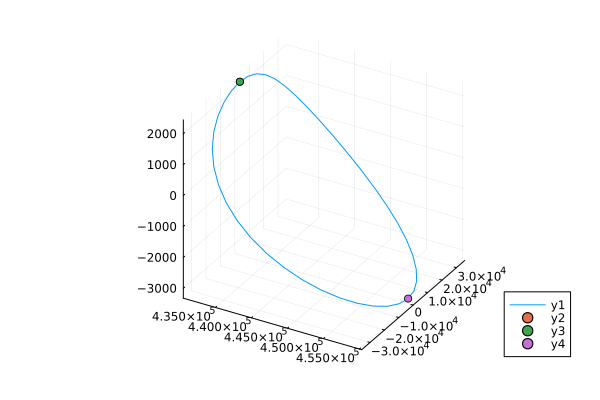

In [144]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])


#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

In [145]:
x_initial_ref

6-element Vector{Float64}:
 1.0e-9
 0.0
 0.0
 0.0
 1.0e-9
 0.0

In [146]:
#reference_traj_1 = [reference_trajectory reference_trajectory]

In [147]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [148]:
#just test to see if it solves

all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

#there was nothing in place for all_Ad_1, maybe a bug? 
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2)
display("solving")
display(X)
Xm, Um = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 82)
sign: real
vexity: affine
id: 994…560

SLOW_PROGRESS::TerminationStatusCode = 19

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


(nothing, nothing)

In [149]:
Um

In [150]:
#normalized_xm2 = Xm[:,2]/norm(Xm[:,2])
#dot(unstable_directions[:,2], normalized_xm2)

In [152]:
#check the constraint

#this is because the constraint is from 2:Nh
constraint_satisfied = zeros(N_h)

for i=1:N_h
    constraint_satisfied[i] = dot(Xm[:,i], unstable_directions_2[:,i])
end

#constraint is not being satisfied... has to do with the cost function. whenever I have a
#tracking cost with a weight of 1e-2 and a control cost with scale 1, it doesn't work. However, 
#when I remove the cost on the controls and make the weight less on the tracking (1e-5) it works (up to the last point)

#with just a tracking cost with a weight of 1e-2 it doesn't satisfy the constraint fully

MethodError: MethodError: no method matching getindex(::Nothing, ::Colon, ::Int64)

In [153]:
constraint_satisfied[1]

0.0

In [154]:
constraint_satisfied[15]

0.0

In [155]:
Xm[:,18]/norm(Xm[:,18])

MethodError: MethodError: no method matching getindex(::Nothing, ::Colon, ::Int64)

In [156]:
unstable_directions[:,18]

6-element Vector{Float64}:
  0.8763990557853825
 -0.253324931452996
 -0.003152202237007567
  0.3829713680353936
 -0.14467125717389165
 -0.01201650351419272

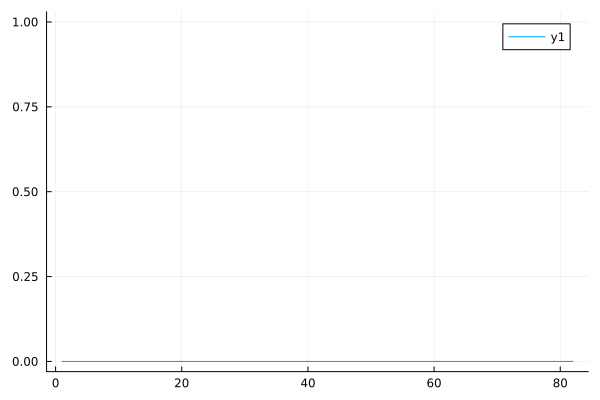

In [157]:
constraint_bool = constraint_satisfied .> 0

plot(constraint_bool)

In [158]:
constraint_bool[44]

false

In [159]:
Xm 

In [160]:
#for one period 40 controls
xtraj_test = integrate_oneperiod(Xm[:,1] + reference_trajectory[:,1], Um[:,1:40])

MethodError: MethodError: no method matching getindex(::Nothing, ::Colon, ::Int64)

In [161]:
Xm[:,1]

MethodError: MethodError: no method matching getindex(::Nothing, ::Colon, ::Int64)

In [162]:
delta_test = xtraj_test - reference_trajectory

UndefVarError: UndefVarError: `xtraj_test` not defined

In [163]:
delta_test[:,1]

UndefVarError: UndefVarError: `delta_test` not defined

In [164]:
delta_test - Xm[:,1:41]

UndefVarError: UndefVarError: `delta_test` not defined

In [165]:
xtraj_test[:,1] - reference_trajectory[:,1]

UndefVarError: UndefVarError: `xtraj_test` not defined

In [166]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [167]:
delta_test[:,1]

UndefVarError: UndefVarError: `delta_test` not defined

In [168]:
Xm[:,1]

MethodError: MethodError: no method matching getindex(::Nothing, ::Colon, ::Int64)

In [169]:
constraint_satisfied_ndynamics = zeros(41)

for i=1:41
    constraint_satisfied_ndynamics[i] = dot(delta_test[:,i], unstable_directions[:,i])
end

UndefVarError: UndefVarError: `delta_test` not defined

In [170]:
delta_test[:,3]/norm(delta_test[:,3])

UndefVarError: UndefVarError: `delta_test` not defined

In [171]:
unstable_directions[:,3]

6-element Vector{Float64}:
  0.6698714398554894
 -0.5746959448202161
  0.024741028496369805
  0.43490837464099624
 -0.1750429667418608
  0.024482075962007122

In [172]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

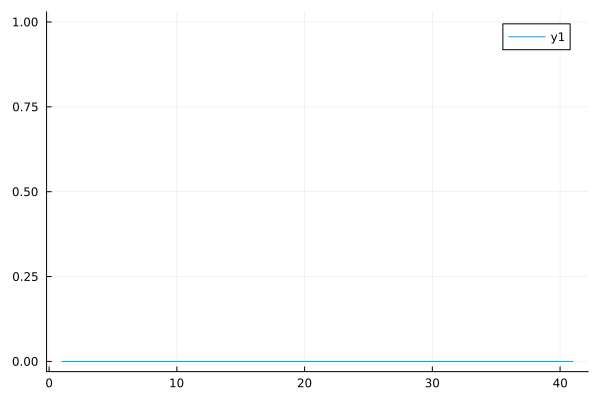

In [173]:
plot(constraint_satisfied_ndynamics .>0)

In [174]:
Xm[:,41]/norm(Xm[:,41])

MethodError: MethodError: no method matching getindex(::Nothing, ::Colon, ::Int64)

In [175]:
unstable_directions[:,end]

6-element Vector{Float64}:
  0.5935997677778413
 -0.6423215383474877
  0.013967734765510604
  0.4049742470161904
 -0.2651769941723249
  0.023329819329140123

In [176]:
dot(Xm[:,41], unstable_directions[:,end])

MethodError: MethodError: no method matching getindex(::Nothing, ::Colon, ::Int64)

In [177]:
plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

UndefVarError: UndefVarError: `xtraj_test` not defined

In [178]:
final = Xm + [reference_trajectory reference_trajectory]

MethodError: MethodError: no method matching +(::Nothing, ::Matrix{Float64})

Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:587
  +(!Matched::MutableArithmetics.Zero, ::Any)
   @ MutableArithmetics ~/.julia/packages/MutableArithmetics/NIXlP/src/rewrite.jl:60
  +(::Any, !Matched::MutableArithmetics.Zero)
   @ MutableArithmetics ~/.julia/packages/MutableArithmetics/NIXlP/src/rewrite.jl:61
  ...


In [179]:
#test out the integration function
#xtraj_test = integrate_oneperiod(final[:,1], Um[:,1:39])

In [180]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [181]:
plot(Um[1,:])

MethodError: MethodError: no method matching getindex(::Nothing, ::Int64, ::Colon)

In [182]:
plot(Um[2,:])

MethodError: MethodError: no method matching getindex(::Nothing, ::Int64, ::Colon)

In [183]:
plot(Um[3,:])

MethodError: MethodError: no method matching getindex(::Nothing, ::Int64, ::Colon)

In [184]:
Xm[:,21]

MethodError: MethodError: no method matching getindex(::Nothing, ::Colon, ::Int64)

In [185]:
final

UndefVarError: UndefVarError: `final` not defined

In [186]:
N_h

82

In [187]:
#check out the 1 period solve

#the x trajectory is generated using the linear dynamics
plot(final[1,1:41], final[2,1:41], final[3,1:41])
#scatter!([final[1,1]], [final[2,1]], [final[3,1]])

UndefVarError: UndefVarError: `final` not defined

In [188]:
1e-5*V

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  0.0190115    -0.000954175   0.00066267   …   0.0168399     0.000453411
 -0.000954175   8.13059e-5   -2.44069e-5      -0.0008777    -2.49275e-5
  0.00066267   -2.44069e-5    5.60468e-5       0.000580446  -8.69069e-6
  0.0165593    -0.000761513   0.000597065      0.0145972     0.000388989
  0.0168399    -0.0008777     0.000580446      0.0149534     0.000402045
  0.000453411  -2.49275e-5   -8.69069e-6   …   0.000402045   3.57316e-5

[:, :, 2] =
 0.0185191    0.000656731   0.000597923  …  0.0174213     0.0002896
 0.000656731  4.9881e-5     2.8534e-5       0.000582714   5.63309e-6
 0.000597923  2.8534e-5     4.54661e-5      0.000554462  -2.19796e-5
 0.0155301    0.000621274   0.000522036     0.014512      0.000228802
 0.0174213    0.000582714   0.000554462     0.0164411     0.000276338
 0.0002896    5.63309e-6   -2.19796e-5   …  0.000276338   5.04139e-5

[:, :, 3] =
 0.0172801    0.00192384    0.000486025  …  0.0173255     0.000123342
 0.00192384   0.

In [189]:
norm(final[:,1] - final[:,40])

UndefVarError: UndefVarError: `final` not defined

In [190]:
#this initial condition is working
#x_initial_ref = [1e-4, 0, 0, 0, 1e-4, 0]

#x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]


#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]

In [191]:
# xposedeviation = x_initial_ref[1] * L*1e3 #in meters

# vyposedeviation = x_initial_ref[5]*V_*1e3 #in m/s

# display(xposedeviation)
# display(vyposedeviation)

In [192]:
#this is one set of jacobians. if starting from beginning 

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [193]:
all_Ad[:,:,21:end]

6×6×21 Array{Float64, 3}:
[:, :, 1] =
  1.02016      -0.000262999  -0.000825479  …   0.0317049   -0.000102186
 -0.00114643    0.995394      4.69698e-5       0.368929     4.36108e-6
 -0.000827485   2.17096e-8    0.99178         -4.36108e-6   0.370286
  0.108687     -0.00212507   -0.00444441       0.170803    -0.000825479
 -0.00926331   -0.024728      0.000379314      0.980815     4.69698e-5
 -0.00446601    2.92306e-7   -0.044214     …  -4.69698e-5   0.99178

[:, :, 2] =
  1.02002      -0.00159618  -0.000815326  …  0.0315394   -0.000101024
 -0.00248028    0.995547     0.000100523     0.368939     1.10048e-5
 -0.000820387   5.41087e-5   0.991768        2.35752e-6   0.370285
  0.107723     -0.00929555  -0.00438148      0.169466    -0.000815326
 -0.0164393    -0.0236994    0.000666346     0.980891     0.000100523
 -0.00442771    0.00029199  -0.0442779    …  7.38914e-6   0.991768

[:, :, 3] =
  1.01976      -0.00288821   -0.000791586  …  0.0313781   -9.81748e-5
 -0.00377442    0.995845      

In [194]:
#another set of jacobians if starting from half

all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,1:20], dims=3)
all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,1:20], dims=3)

all_Ad_2 = cat(all_Ad_half, all_Ad_half, dims=3)
all_Bd_2 = cat(all_Bd_half, all_Bd_half, dims=3)

#All Ad1 is if you start from the beginning (2 orbits worth of jacobians) and all_Ad_2 is if you start from the half (2 orbits worth of jacobians).
#need to also have two sets of cost to go and unstable direction matrices that we pass in in the update_prob function 

6×3×82 Array{Float64, 3}:
[:, :, 1] =
  0.0689974     0.0039238   -9.48638e-6
 -0.0039238     0.0687129    3.23903e-7
 -9.48638e-6   -3.23903e-7   0.0688389
  0.371994      0.0317049   -0.000102186
 -0.0317049     0.368929     4.36108e-6
 -0.000102186  -4.36108e-6   0.370286

[:, :, 2] =
  0.0689967    0.00390844  -9.38381e-6
 -0.00393917   0.0687138    9.41458e-7
 -9.42618e-6   2.99211e-7   0.0688388
  0.371986     0.0315394   -0.000101024
 -0.0318705    0.368939     1.10048e-5
 -0.000101595  2.35752e-6   0.370285

[:, :, 3] =
  0.0689945   0.00389347  -9.12426e-6
 -0.00395418  0.0687164    1.51774e-6
 -9.20656e-6  8.91857e-7   0.0688384
  0.371963    0.0313781   -9.81748e-5
 -0.0320322   0.368966     1.71896e-5
 -9.92829e-5  8.76254e-6   0.37028

;;; … 

[:, :, 80] =
  0.0689912    0.0039685   -8.83901e-6
 -0.0038792    0.0687204   -1.42086e-6
 -8.72148e-6  -2.02044e-6   0.0688376
  0.371927     0.0321865   -9.53714e-5
 -0.0312245    0.36901     -1.44955e-5
 -9.37889e-5  -2.25684e-5 

In [195]:
unstable_directions_half = cat(unstable_directions[:,21:end], unstable_directions[:,1:20], dims=2)
V_half = cat(P[:,:,21:end], P[:,:,1:20], dims=3)

#unstable directions if you start from the beginning
unstable_directions_2_1 = unstable_directions_2
#this is the unstable direction if you start at the half
unstable_directions_2_2 = cat(unstable_directions_half, unstable_directions_half, dims=2)


#cost to go if you start from the beginning
V_2orbits_1 = V_2orbits

#cost to go in you start at the half
V_2orbits_2 = cat(V_half, V_half, dims=3)

6×6×1312 Array{Float64, 3}:
[:, :, 1] =
  785.478   -267.751    -22.5639   1302.42     483.922   -24.4011
 -267.751     93.9171     8.25967  -440.055   -167.833     7.66047
  -22.5639     8.25967    2.29717   -36.7829   -14.4095   -1.42377
 1302.42    -440.055    -36.7829   2165.73     797.593   -41.1175
  483.922   -167.833    -14.4095    797.593    302.191   -14.4572
  -24.4011     7.66047   -1.42377   -41.1175   -14.4572    4.61835

[:, :, 2] =
  764.88    -300.249    -21.1635   1294.96     438.937   -19.6927
 -300.249    120.04       8.80449  -504.695   -176.1       6.92282
  -21.1635     8.80449    2.02961   -35.1996   -12.8839   -1.9508
 1294.96    -504.695    -35.1996   2198.86     736.141   -34.2894
  438.937   -176.1      -12.8839    736.141    259.71    -10.1244
  -19.6927     6.92282   -1.9508    -34.2894   -10.1244    6.10071

[:, :, 3] =
  744.982   -329.294    -19.5266   1285.43     400.188    -14.7499
 -329.294    147.249      9.04612  -565.01    -181.195      5.62478
  

In [196]:
#pseudo code

orbit_count = 0
orbits = true

#number of orbits you want to plan go for
orbit_num = 100


halforbit_num = orbit_num*2 

#this is for each orbit plan

optimal_Δx = zeros(nx, N_period)
optimal_u = zeros(nu, N_period-1)

#data for all the orbits
all_optimal_Δx = zeros(nx, 21, halforbit_num)
all_optimal_x = zeros(nx, 21, halforbit_num)
all_optimal_u = zeros(nu, 20, halforbit_num)


#optimal_Δx[:,1] = x_initial_ref


#while orbits
    
#    orbits=false
    
#for i=1:N_period-1
 
#i is now the number of times it orbits
for i=1:halforbit_num
        
    #Ad_k = cat(all_Ad_3p[:,:,i:end],all_Ad_3p[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd_3p[:,:,i:end],all_Bd_3p[:,:,1:(i-1)], dims=3)
    
    #Ad_k = cat(all_Ad[:,:,i:end],all_Ad[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd[:,:,i:end],all_Bd[:,:,1:(i-1)], dims=3)
    
    #Ad_k = all_Ad_3p[:,:,1:N_h]
    #Bd_k = all_Bd_3p[:,:,1:N_h]
      
    #horizon is two orbits ahead
    #all_Ad_k = cat(Ad_k, Ad_k, dims=3)
    #all_Bd_k = cat(Bd_k, Bd_k, dims=3)
        
    #cons, X, U = update_prob(optimal_Δx[:,i], all_Ad_k, all_Bd_k)
    
    #if you start from the beginning use the appropriate set of jacobians
    if i%2 != 0
        #println("using jacobian 1")
        all_Ad_k = all_Ad_1
        all_Bd_k = all_Bd_1
        unstable_directions_k = unstable_directions_2_1
        P_k = V_2orbits_1        
    else
        #println("using jacobian 2")
        all_Ad_k = all_Ad_2
        all_Bd_k = all_Bd_2
        unstable_directions_k = unstable_directions_2_2
        P_k = V_2orbits_2
    end
        
    cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_k, all_Bd_k, P_k, unstable_directions_k)
        
    Xm, Um = solve_opt(cons, X, U,N_h)
    
    #get the optimal controls for half a period (20 for this example)
        
    optimal_u = Um[:,1:20]
        
    #size N_period
        
    orbit_count += 1
    
    #rollout on the nonlinear dynamics
    
    if i%2 != 0
        
        #print("from beginning")
        
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,1] + Xm[:,1], optimal_u)

        #this is the deviation from the reference
        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,1:21]
        
        #integrate the initial condition by all the optimal controls from the solver        
    else
        
        #print("this is reference trajectory at half: ", reference_trajectory[:,21])
        #println("from half")
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,21] + Xm[:,1], optimal_u)

        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,21:41] 
        #integrate the initial condition by all the optimal controls from the solver
        
    end
    
    all_optimal_x[:,:,orbit_count] = xtraj_halfperiod
    
    all_optimal_u[:,:,orbit_count] = optimal_u
    
    println("Half Revolution solved: ", i)
    
    #update the intiial condition for the next rev (has to be a delta)
    x_initial_ref_scaled = all_optimal_Δx[:,end, orbit_count]

    #println("this is the initial condition for the next rev: ", x_initial_ref)
    
end  

SLOW_PROGRESS::TerminationStatusCode = 19

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


MethodError: MethodError: no method matching getindex(::Nothing, ::Colon, ::UnitRange{Int64})

In [197]:
all_optimal_Δx

6×21×200 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] 

In [199]:
rev1 = all_optimal_x[:,:,1]
rev2 = all_optimal_x[:,:,2]
rev3 = all_optimal_x[:,:,3]
rev4 = all_optimal_x[:,:,4]
rev5 = all_optimal_x[:,:,5]
# rev20 = all_optimal_x[:,:,20]

# rev59 = all_optimal_x[:,:,59]
# rev60 = all_optimal_x[:,:,60]
#rev25 = all_optimal_x[:,:,25]

6×21 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

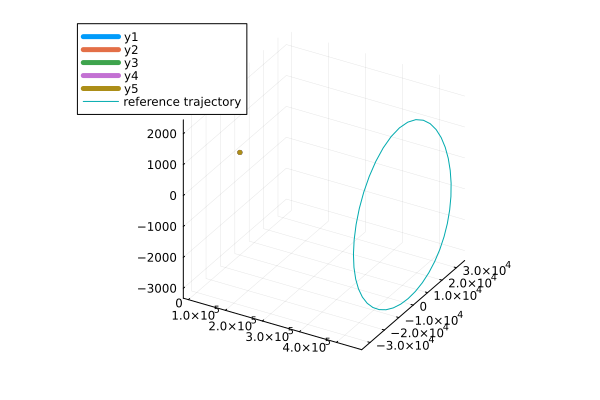

In [200]:
plot(rev1[1,:], rev1[2,:], rev1[3,:], lw=5)
#scatter!([rev1[1,1]],[rev1[2,1]],[rev1[3,1]], lw=5)
plot!(rev2[1,:], rev2[2,:], rev2[3,:], lw=5)
plot!(rev3[1,:], rev3[2,:], rev3[3,:], lw=5)
plot!(rev4[1,:], rev4[2,:], rev4[3,:], lw=5)
plot!(rev5[1,:], rev5[2,:], rev5[3,:], lw=5)
#plot!(rev59[1,:], rev59[2,:], rev59[3,:], lw=5)
#plot!(rev60[1,:], rev60[2,:], rev60[3,:], lw=5)

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="reference trajectory")

#scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

In [201]:
1e-3*L

385.0

In [202]:
all_optimal_x_formatted = zeros(6, N_period, orbit_num)
all_optimal_Δx_formatted = zeros(6, N_period, orbit_num)

6×41×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] 

In [203]:
#have orbit_num trajectories of N knot points

for i=1:orbit_num
    
    all_optimal_x_formatted[:,1:21,i] = all_optimal_x[:,:,(2*i-1)]
    
    #2:end is used to not repeat the same element twice
    all_optimal_x_formatted[:,22:end,i] = all_optimal_x[:,2:end,(2*i)]
    
    
    all_optimal_Δx_formatted[:,1:21,i] = all_optimal_Δx[:,:,(2*i-1)]
    
    all_optimal_Δx_formatted[:,22:end,i] = all_optimal_Δx[:,2:end,(2*i)]
    
end

In [204]:
all_optimal_x

6×21×200 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] 

In [205]:
all_optimal_x_formatted

6×41×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] 

In [206]:
all_xtraj = reshape(all_optimal_x_formatted, (6, N_period*orbit_num))

all_Δxtraj = reshape(all_optimal_Δx_formatted, (6, N_period*orbit_num))
#all_xtraj = reshape(all_optimal_x, (6, 210))

6×4100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [207]:
for i=1:100
    deltaxsub = all_Δxtraj[41*(i-1)+1:41*i]

    for i=1:41
        plot(deltaxsub[1,:], deltaxsub[2,:], deltaxsub[3,:], lw=5)
    end
end

In [208]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 198] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0 

In [209]:
all_utraj = reshape(all_optimal_u, (3, (N_period-1)*orbit_num))

3×4000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [210]:
all_utraj

3×4000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

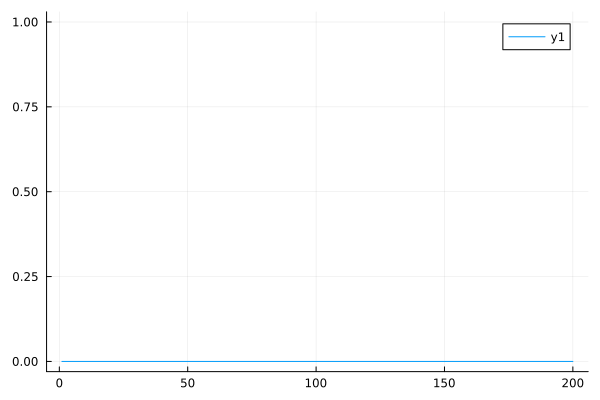

In [211]:
plot(all_utraj[1,1:200])

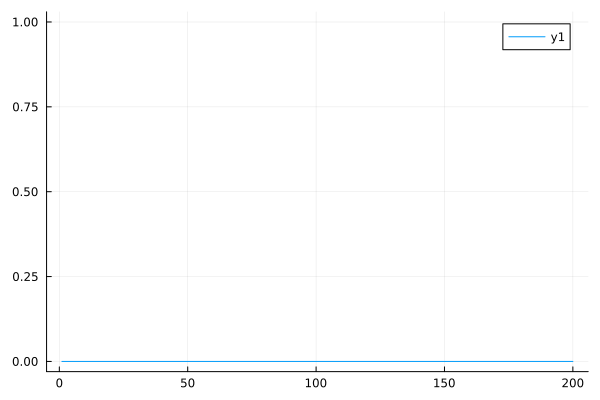

In [212]:
plot(all_utraj[2,1:200])

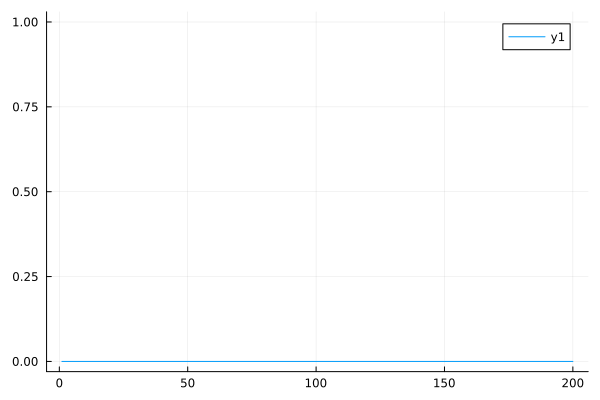

In [213]:
plot(all_utraj[3,1:200])

In [214]:
#this is for 5 orbits
#plot(all_utraj[1,1:200])

In [215]:
# plot(all_utraj[2,1:400])

In [216]:
# plot(all_utraj[3,1:400])

In [217]:
# size(all_utraj)

In [218]:
one_orbit = all_utraj[:,1:40]

3×40 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

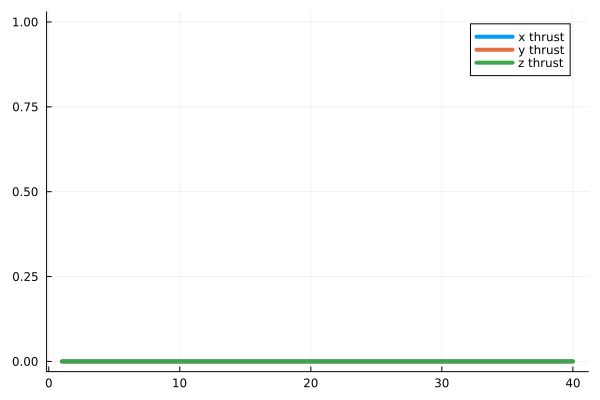

In [219]:
#the beginning thrust is to get it back on track since the initialization is off by 1e-3

plot(one_orbit[1,:], label="x thrust", linewidth=4)

plot!(one_orbit[2,:], label="y thrust", linewidth=4)

plot!(one_orbit[3,:], label="z thrust", linewidth=4)

In [220]:
#once we are at the orbit this is what it looks like
last_orbit = all_utraj[:,3961:end]

3×40 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

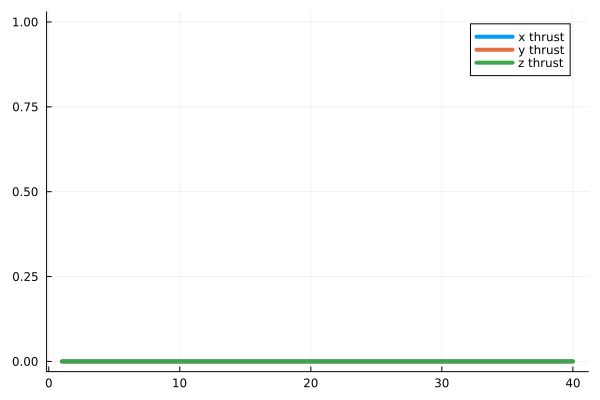

In [221]:
plot(last_orbit[1,:], label="x thrust", linewidth=4)

plot!(last_orbit[2,:], label="y thrust", linewidth=4)

plot!(last_orbit[3,:], label="z thrust", linewidth=4)

In [222]:
all_xtraj

6×4100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

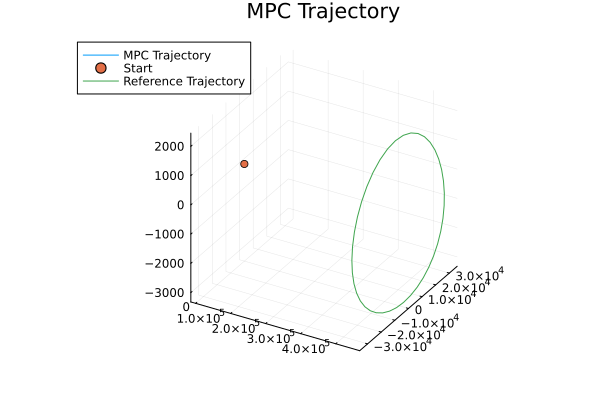

In [224]:
#plot the 100 orbits

plot(all_xtraj[1,1:200], all_xtraj[2,1:200], all_xtraj[3,1:200], label="MPC Trajectory", title="MPC Trajectory")

scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label = "Reference Trajectory")

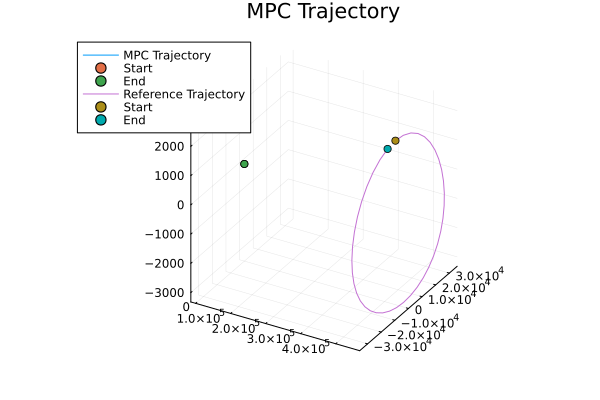

In [225]:
iter = 40

plot(all_xtraj[1,1:iter], all_xtraj[2,1:iter], all_xtraj[3,1:iter], label="MPC Trajectory", title="MPC Trajectory")
scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")
scatter!([all_xtraj[1,iter]], [all_xtraj[2,iter]], [all_xtraj[3,iter]], label="End")
plot!(reference_trajectory[1,1:iter], reference_trajectory[2,1:iter], reference_trajectory[3,1:iter], label = "Reference Trajectory")
scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]], label="Start")
scatter!([reference_trajectory[1,iter]], [reference_trajectory[2,iter]], [reference_trajectory[3,iter]], label="End")


In [226]:
#plot the final orbit
size(all_xtraj)

(6, 4100)

In [227]:
#i = 50
#plot(all_xtraj[1,40*(i-1)+1:40*i], all_xtraj[2,40*(i-1)+1:40*i], all_xtraj[3,40*(i-1)+1:40*i], label="MPC Trajectory", title="MPC Trajectory",lw=3)


#plot!(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory",lw=3)
#plot!(all_xtraj[1,81:120], all_xtraj[2,81:120], all_xtraj[3,81:120], label="MPC Trajectory", title="MPC Trajectory",lw=3)



#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3)


#plot(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory", lw=3)
#plot(all_xtraj[1,81:end], all_xtraj[2,81:end], all_xtraj[3,81:end], label="MPC Trajectory", title="MPC Trajectory", lw=3)

#scatter!([all_xtraj[1,1]],[all_xtraj[2,1]], [all_xtraj[3,1]], label="1")

#scatter!([all_xtraj[1,40]],[all_xtraj[2,40]], [all_xtraj[3,40]], label="40")

#scatter!([all_xtraj[1,41]],[all_xtraj[2,41]], [all_xtraj[3,41]], label="41")

#scatter!([all_xtraj[1,81]],[all_xtraj[2,81]], [all_xtraj[3,81]], label="80")

In [228]:
#plot(optimal_u[1,:].*acceleration_scale)

In [229]:
#plot(optimal_u[2,:])

In [230]:
#plot(optimal_u[3,:])

In [231]:
acceleration_scale

20354.29089708545

In [232]:
scaled_control = all_utraj./acceleration_scale

3×4000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [233]:
#integrate over the timestep to get the velocity cost in km/s
x_cost = sum(abs.(scaled_control[1,:]))*(Δt*time_scale)
y_cost = sum(abs.(scaled_control[2,:]))*(Δt*time_scale)
z_cost = sum(abs.(scaled_control[3,:]))*(Δt*time_scale)

0.0

In [234]:
#velocity cost in m/s
x_cost_ms = x_cost*1e3
y_cost_ms = y_cost*1e3
z_cost_ms = z_cost*1e3

display(x_cost_ms)
display(y_cost_ms)
display(z_cost_ms)

0.0

0.0

0.0

In [235]:
all_cost = x_cost_ms + y_cost_ms + z_cost_ms 

0.0

In [236]:
cost_per_rev = all_cost/orbit_num

0.0

In [237]:
#Exclude the first 10 timesteps to fix the injection error
x_cost_good = sum(abs.(scaled_control[1,42:end]))*(Δt*time_scale) *1e3
y_cost_good = sum(abs.(scaled_control[2,42:end]))*(Δt*time_scale) *1e3
z_cost_good = sum(abs.(scaled_control[3,42:end]))*(Δt*time_scale) *1e3

display(x_cost_good)
display(y_cost_good)
display(z_cost_good)

0.0

0.0

0.0

In [238]:
#cost for 95 revs
all_cost_good = x_cost_good + y_cost_good + z_cost_good

0.0

In [239]:
#final_mpc = reference_trajectory + optimal_x

In [240]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")

In [241]:
#initially
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]],[final_mpc[3,1]], label= "Start Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [242]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label= "Start Point")
#scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]], label= "End Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [243]:
#diff = final_mpc - reference_trajectory

In [244]:
#plot(diff[1,:])
#plot!(diff[2,:])
#plot!(diff[3,:])

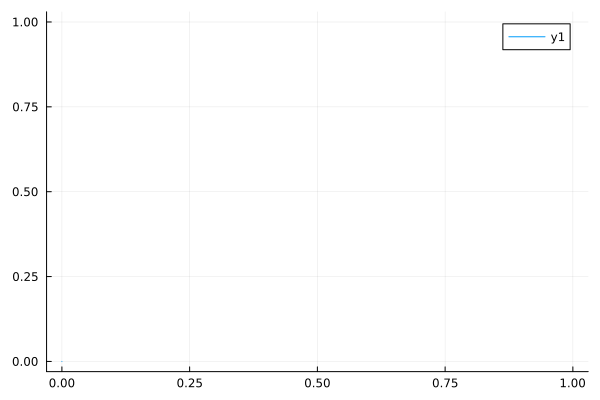

In [245]:
plot(all_xtraj[1,:], all_xtraj[2,:])

In [247]:
all_xtraj[:,end]

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [248]:
all_optimal_x[:,:,end]

6×21 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [249]:
dot(all_optimal_x[:,end,end], unstable_directions_2[:,21])    

0.0

In [250]:
end_state = all_xtraj[:,end]

end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


end_state_traj = get_state(end_state_sim)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/faustovega/.julia/packages/SciMLBase/QSc1r/src/integrator_interface.jl:579


6×97446 Matrix{Float64}:
 0.0      -0.681059        -2.69382     …  -4677.75       -4677.75
 0.0       1.04394e-5       8.21065e-5        -4.0551e-5     -4.05592e-5
 0.0       0.0              0.0                0.0            0.0
 0.0  -13621.8         -27097.0               -5.91372e5     -5.90225e5
 0.0       0.313186         1.23867           -1.18469e9     -1.18469e9
 0.0       0.0              0.0         …      0.0            0.0

In [251]:
#testing
#end_state_sim = reference_trajectory[:,end]

In [252]:
delta_end = end_state - reference_trajectory[:,end]

6-element Vector{Float64}:
 -431249.9493668459
       0.003851463980650329
   -2286.769795836855
      -0.002199234649276377
  -15649.014948352466
      -0.0001293855647662

In [253]:
#end_state_test = reference_trajectory[:,end] - delta_end

In [254]:
#correct_end_state = end_state_test - reference_trajectory[:,end]

In [255]:
#end_state_sim_correct = just_dynamics_integrate(end_state_test, 2.0*sol_t_final[end])


#end_state_traj_correct = get_state(end_state_sim_correct)

In [256]:
deltaaa = xtraj_test[:,1:21] - all_xtraj[:,1:21]

UndefVarError: UndefVarError: `xtraj_test` not defined

In [257]:
plot(deltaaa[6,:])

UndefVarError: UndefVarError: `deltaaa` not defined

In [258]:
half_test = all_xtraj[:,1:21] - reference_trajectory[:,1:21]

6×21 Matrix{Float64}:
     -4.3125e5  -431267.0        -4.31338e5  …     -4.54408e5     -4.5462e5
      0.0         -5775.21   -11343.6           -5115.62          -4.38578e-5
  -2286.77        -2237.81    -2094.63           3131.97        3158.04
      0.0          -101.372    -306.583         -1134.14          -3.00529e-5
 -15649.0        -15364.7    -14545.9           13670.1        13831.2
      0.0           262.025     504.475      …    140.265          4.40886e-7

In [259]:
constraint_check_test = zeros(21)
for i=1:21
    constraint_check_test[i] = dot(half_test[:,i], unstable_directions[:,i])

end


In [260]:
constraint_check_test

21-element Vector{Float64}:
 -251872.04974890396
 -264880.7778892556
 -280048.7149617457
 -296008.40465245437
 -311616.6068065055
 -326109.225211323
 -339094.47219168517
 -350457.3424712188
 -360248.08759907115
 -368592.9419122275
       ⋮
 -386312.43335355836
 -390122.88904771995
 -392986.69498167787
 -394929.6332485693
 -395961.8343310189
 -396081.6085561958
 -395278.7161396956
 -393534.9476599204
 -390825.243855422

In [261]:
#check the constraint...
constraint_check = zeros(4100)
for k=1:100
    for i=1:41

        constraint_check[41*(k-1)+i] = dot(unstable_directions[:,i], all_Δxtraj[:, 41*(k-1)+i]) > 0 

    end
end

In [262]:
constraint_check

4100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

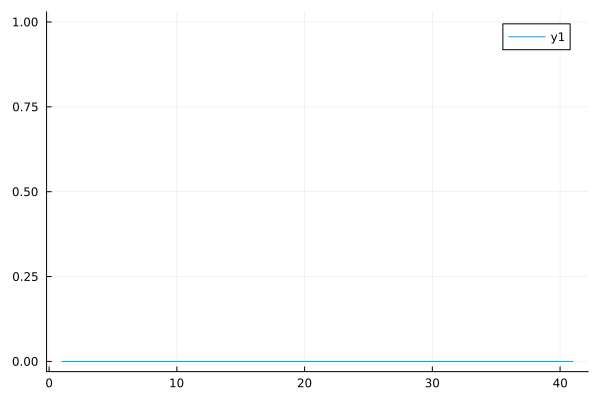

In [263]:
plot(constraint_check[1:41])

In [264]:
unstable_directions[:,end]


#for the negative manifold, the final state is satisfying the constraint and that's why it goes to the 
#left 

#however, for the positive manifold, it is satisfying the negative manifold constraint...

6-element Vector{Float64}:
  0.5935997677778413
 -0.6423215383474877
  0.013967734765510604
  0.4049742470161904
 -0.2651769941723249
  0.023329819329140123

In [265]:
dot(delta_end, unstable_directions[:,end])

-251872.0554141119

In [266]:
#check this constraint 
#works with pi/5 too 

c_test = unstable_directions[:,end]/tan(pi/6)
#c_test = unstable_directions[:,end]/tan((pi/2) - deg2rad(60))

manifold_constraint_test = norm(delta_end) - c_test'*(delta_end)

manifold_constraint_test
#push!(cons, manifold_constraint <= 0)

867795.0442911743

In [267]:
#angle away from the unstable manifold
dot(unstable_directions[:,end], delta_end)*norm(delta_end)*180/pi

-6.227640326897568e12

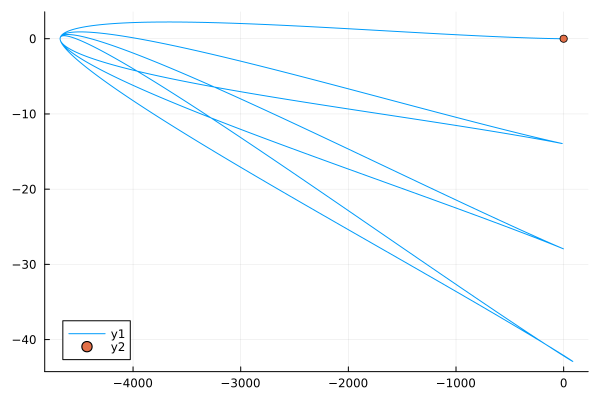

In [268]:
#escapes on the right for positive unstable direction!
plot(end_state_traj[1,:], end_state_traj[2,:])

scatter!([end_state_traj[1,1]], [end_state_traj[2,1]])

In [269]:
#plot(end_state_traj_correct[1,:], end_state_traj_correct[2,:])

#goes to the right when it is in the positive manifold direction. hypothesis is true. however, 
#the solver is giving solutions that does not satisfy this constraint. need to figure out why...

In [270]:
#needs to be a super small perturbation in order to stay stable

forward_rollout = zeros(6, N_period)

#forward_rollout[:,1] = [1e-3, 0, 0, 0, 1e-6,0]


forward_rollout[:,1] = [1e-9, 0, 0, 0, 1e-9, 0]

for i=1:N_period-1
   
    #diverges with no control 
    #forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i]
    
    #with disturbances it just blows up
    forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i] #+ randn(6)*1e-4
    
end
    

In [271]:
reference_trajectory

6×41 Matrix{Float64}:
     4.3125e5  431267.0        4.31338e5  …  431267.0        4.3125e5
     0.0         5775.21   11343.6            -5775.22      -0.00385146
  2286.77        2237.81    2094.63            2237.81    2286.77
     0.0          101.372    306.583           -101.372      0.00219923
 15649.0        15364.7    14545.9            15364.7    15649.0
     0.0         -262.025   -504.475      …     262.025      0.000129386

In [272]:
nocontrol = forward_rollout + reference_trajectory

6×41 Matrix{Float64}:
     4.3125e5  431267.0        4.31338e5  …  431267.0        4.3125e5
     0.0         5775.21   11343.6            -5775.22      -0.0038536
  2286.77        2237.81    2094.63            2237.81    2286.77
     0.0          101.372    306.583           -101.372      0.00220052
 15649.0        15364.7    14545.9            15364.7    15649.0
     0.0         -262.025   -504.475      …     262.025      0.000129458

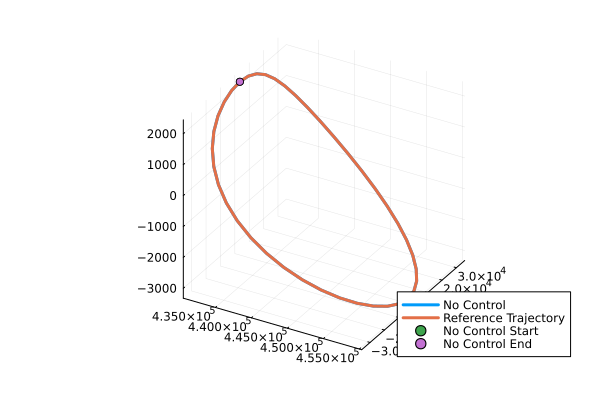

In [273]:
plot(nocontrol[1,:], nocontrol[2,:], nocontrol[3,:], lw=3, label="No Control")
plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
scatter!([nocontrol[1,1]], [nocontrol[2,1]], [nocontrol[3,1]], label="No Control Start")
scatter!([nocontrol[1,end]], [nocontrol[2,end]],[nocontrol[3,end]], label="No Control End")

In [274]:
# plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], lw=3, label="MPC Control")
# plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
# scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label="No Control Start")
# scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]],  label="No Control End", aspectratio = true)

In [275]:
position_tube_norm = zeros(N_period*orbit_num)

velocity_tube_norm = zeros(N_period*orbit_num)

4100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [276]:
orbit_num

100

In [277]:
svd(V[:,:,1]).S

6-element Vector{Float64}:
 4844.461336416785
   20.709119549916846
    5.128290395379033
    0.36267834497211665
    0.19008096989191653
    0.003003371380280053

In [278]:
for i=1:N_period*orbit_num
   
    position_tube_norm[i]= norm(all_Δxtraj[1:3,i])
    
    velocity_tube_norm[i]= norm(all_Δxtraj[4:6,i])
    
end

In [279]:
ctg_constraint = zeros(6, N_period)
dist_from_center = zeros(6, N_period)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [280]:
(ones(6).*0.1)./eigen(V[:,:,1]).values

6-element Vector{Float64}:
 33.29591560419668
  0.5260915916875339
  0.2757264153934738
  0.01949967577696212
  0.004828790512265019
  2.0642129858335338e-5

In [281]:
test_v = (ones(6).*0.1)./eigen(V[:,:,1]).vectors

6×6 Matrix{Float64}:
 -0.162457  -0.220614  -1.74333   -4.75631    0.715026   0.159649
 -0.161389   0.149594   1.6266    -2.23551   -0.248096  -3.22137
 -5.65074   -0.990653   0.152505   0.135614  -0.808269   4.54873
  0.239827  -4.41912   -1.91557   -1.19559   -0.139029   0.183018
  0.400239   0.173192   1.35676    1.08468    0.188038   0.180352
  4.19859   -1.66839    0.134255  -0.151044   2.00324    6.72297

In [282]:
test_v * [1,1,1,0,0,0]

6-element Vector{Float64}:
 -2.126404372004712
  1.6148026468401833
 -6.488886712531757
 -6.094857693186198
  1.9301892092807638
  2.6644559883813157

In [283]:
V

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 1901.15    -95.4175   66.267     1655.93    1683.99    45.3411
  -95.4175    8.13059  -2.44069    -76.1513   -87.77    -2.49275
   66.267    -2.44069   5.60468     59.7065    58.0446  -0.869069
 1655.93    -76.1513   59.7065    1457.06    1459.72    38.8989
 1683.99    -87.77     58.0446    1459.72    1495.34    40.2045
   45.3411   -2.49275  -0.869069    38.8989    40.2045   3.57316

[:, :, 2] =
 1851.91    65.6731    59.7923   1553.01    1742.13    28.96
   65.6731   4.9881     2.8534     62.1274    58.2714   0.563309
   59.7923   2.8534     4.54661    52.2036    55.4462  -2.19796
 1553.01    62.1274    52.2036   1321.44    1451.2     22.8802
 1742.13    58.2714    55.4462   1451.2     1644.11    27.6338
   28.96     0.563309  -2.19796    22.8802    27.6338   5.04139

[:, :, 3] =
 1728.01    192.384     48.6025   1431.37     1732.55    12.3342
  192.384    23.2195     5.93685   165.73      189.617    0.775495
   48.6025    5.93685    3.21884    

In [284]:
for i= 1:N_period

    e_decomp = eigen(V[:,:,i])

    #inverse same as transpose in this case
    y = inv(e_decomp.vectors) * all_Δxtraj[:,i]

    dist_from_center[:,i] = y

    ctg_constraint[:,i] = sqrt.(1e-3 .*ones(6)./e_decomp.values)


end

    

In [ ]:
ctg_constraint


In [ ]:
dist_from_center

In [ ]:
all_Δxtraj[:,1]'*V[:,:,1]*all_Δxtraj[:,1]

In [ ]:
dist_from_center[1,:]*L

In [ ]:
plot(dist_from_center[1,:], label="x")
plot!(ctg_constraint[1,:], label="x axis constraint")

In [ ]:
plot(dist_from_center[2,:], label="y")
plot!(ctg_constraint[2,:], label="y axis constraint")

In [ ]:
plot(dist_from_center[3,:], label="z")
plot!(ctg_constraint[3,:], label="z axis constraint")

In [ ]:
plot(dist_from_center[4,:], label="vx")
plot!(ctg_constraint[4,:], label="vx axis constraint")

In [ ]:
plot(dist_from_center[5,:], label="vy")
plot!(ctg_constraint[5,:], label="vy axis constraint")

In [ ]:
plot(dist_from_center[6,:], label="vz")
plot!(ctg_constraint[6,:], label="vz axis constraint")

In [ ]:
all_Δxtraj[:,1]

In [ ]:
V[:,:,1]

In [ ]:
#test.vectors*diagm(test.values)*test.vectors'

In [ ]:
#inv(test.vectors)

In [ ]:
#test.vectors'

In [ ]:
# #finding the magnitude of the principle axes of the ellipsoid
# magnitude_principle_axes = zeros(6, N_period)


# for i=1:N_period
    
#     magnitude_principle_axes[:,i] = svd(V[:,:,i]).S
    
    
# end

In [ ]:
# plot(magnitude_principle_axes[1,:])
# plot!(magnitude_principle_axes[2,:])
# plot!(magnitude_principle_axes[3,:])

In [ ]:
# plot(magnitude_principle_axes[4,:])
# plot!(magnitude_principle_axes[5,:])
# plot!(magnitude_principle_axes[6,:])

In [ ]:
plot(all_Δxtraj[1,:])

plot!(all_Δxtraj[2,:])

plot!(all_Δxtraj[3,:])

In [ ]:
plot(all_Δxtraj[4,:])

plot!(all_Δxtraj[5,:])

plot!(all_Δxtraj[6,:])